
# __American Dream Affordability Analysis__

This notebook analyzes long-term trends in:

- College tuition (public and private 4-year)
- Median household income
- Median home prices
- Student loan debt
- 30-year mortgage rates
- Inflation (CPI)

It then constructs **real-dollar affordability ratios** such as:

- Tuition / Income (real)
- Home Price / Income (real)
- Student Debt / Income (real)

and compares behavior **before vs after 2000**, with smoothed trends and
polynomial-curve forecasts.

In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

plt.style.use('seaborn-v0_8-talk')

# Plotting defaults
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

DATA_DIR = "datasets"

TUITION_FILE = "tuition-dataset.csv"      # cleaned tuition table with 'Academic Year'
INCOME_FILE = "median_income.csv"         # MEHOINUSA646N
HOME_FILE = "home_prices.csv"             # MSPUS
DEBT_FILE = "student_loan_debt.csv"       # SLOAS
MORTGAGE_FILE = "mortgage30.csv"          # MORTGAGE30US
CPI_FILE = "spi.csv"                      # CPIAUCSL (CPI inflation index)


## __1. Load Raw Data__

In [19]:
tuition = pd.read_csv(f"{DATA_DIR}/{TUITION_FILE}")
income = pd.read_csv(f"{DATA_DIR}/{INCOME_FILE}")
home = pd.read_csv(f"{DATA_DIR}/{HOME_FILE}")
loan = pd.read_csv(f"{DATA_DIR}/{DEBT_FILE}")
mortgage = pd.read_csv(f"{DATA_DIR}/{MORTGAGE_FILE}")
cpi = pd.read_csv(f"{DATA_DIR}/{CPI_FILE}")

print("Tuition shape:", tuition.shape)
print("Income shape:", income.shape)
print("Home prices shape:", home.shape)
print("Student loan debt shape:", loan.shape)
print("Mortgage rates shape:", mortgage.shape)
print("CPI shape:", cpi.shape)

# Quick peek
display(tuition.head())
display(income.head())
display(home.head())
display(loan.head())
display(mortgage.head())
display(cpi.head())


Tuition shape: (55, 11)
Income shape: (41, 2)
Home prices shape: (250, 2)
Student loan debt shape: (76, 2)
Mortgage rates shape: (2851, 2)
CPI shape: (945, 2)


,Academic Year,Private Nonprofit Four-Year,One-Year % Change,Public Four-Year,One-Year % Change.1,Public Two-Year,One-Year % Change.2,Private Nonprofit Four-Year.1,One-Year % Change.3,Public Four-Year.1,One-Year % Change.4
0,1971,14550,NaN,3420,NaN,1510,NaN,23290,NaN,11210,NaN
1,1972,15020,0.032,3850,0.126,1770,0.172,23800,0.022,11940,0.065
2,1973,14870,-0.010,3700,-0.039,1960,0.107,23350,-0.019,11600,-0.028
3,1974,13910,-0.065,3330,-0.100,1830,-0.066,22340,-0.043,10780,-0.071
4,1975,13710,-0.014,3230,-0.030,1500,-0.180,22020,-0.014,10650,-0.012


,observation_date,MEHOINUSA646N
0,1984-01-01,22420
1,1985-01-01,23620
2,1986-01-01,24900
3,1987-01-01,26060
4,1988-01-01,27230


,observation_date,MSPUS
0,1963-01-01,17800
1,1963-04-01,18000
2,1963-07-01,17900
3,1963-10-01,18500
4,1964-01-01,18500


,observation_date,SLOAS
0,2006-01-01,480966.98
1,2006-04-01,487126.04
2,2006-07-01,510548.46
3,2006-10-01,521382.49
4,2007-01-01,544988.55


,observation_date,MORTGAGE30US
0,1971-04-02,7.33
1,1971-04-09,7.31
2,1971-04-16,7.31
3,1971-04-23,7.31
4,1971-04-30,7.29


,observation_date,cpi_index
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


## __2. Helper Functions__

In [20]:
def add_year_from_date(df, date_col="observation_date"):
    """Add a Year column based on a date-like column."""
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["Year"] = df[date_col].dt.year
    return df


def aggregate_to_yearly_mean(df, value_cols, year_col="Year"):
    """Aggregate the given value columns to yearly averages."""
    return df.groupby(year_col)[value_cols].mean().reset_index()


def rename_series_columns(income, home, loan, mortgage, cpi):
    """Rename cryptic FRED series IDs to clear names."""
    income = income.rename(columns={"MEHOINUSA646N": "median_income"})
    home = home.rename(columns={"MSPUS": "median_home_price"})
    loan = loan.rename(columns={"SLOAS": "student_loan_debt"})
    mortgage = mortgage.rename(columns={"MORTGAGE30US": "mortgage_rate"})
    cpi = cpi.rename(columns={"CPIAUCSL": "cpi_index"})
    return income, home, loan, mortgage, cpi


def build_tuition_yearly(tuition_df):
    """Prepare the tuition table with a Year column and main tuition values."""
    df = tuition_df.copy()
    df = df.rename(columns={"Academic Year": "Year"})
    keep_cols = ["Year", "Private Nonprofit Four-Year", "Public Four-Year"]
    keep_cols = [c for c in keep_cols if c in df.columns]
    df = df[keep_cols]
    return df.sort_values("Year")


def add_rolling(df, cols, window=3):
    """Add centered rolling-mean columns for smoothing."""
    df = df.copy()
    for c in cols:
        df[c + "_roll"] = df[c].rolling(window, center=True, min_periods=1).mean()
    return df


def segment_summary(df, label):
    """Print summary averages for a given time segment."""
    print(f"\n=== {label} ===")
    print("Years:", int(df["Year"].min()), "to", int(df["Year"].max()))
    print("Avg private tuition / income (real, 3y avg):",
          df["tuition_private_ratio_real_roll"].mean())
    print("Avg public tuition / income (real, 3y avg):",
          df["tuition_public_ratio_real_roll"].mean())
    print("Avg home price / income (real, 3y avg):",
          df["home_afford_ratio_real_roll"].mean())


def forecast_ratio_poly(df, target_col, horizon=20, degree=2, train_end=None):
    """
    Polynomial regression forecast on Year vs target_col.

    Parameters:
        df: dataframe with 'Year' and target_col
        target_col: column to model (e.g. 'home_afford_ratio_real_roll')
        horizon: how many years into the future to forecast
        degree: polynomial degree (2 = quadratic)
        train_end: optional last Year to use for training (e.g. 2019 to exclude COVID)

    Returns:
        DataFrame with future years and forecast values.
    """
    data = df[["Year", target_col]].dropna().sort_values("Year")
    if train_end is not None:
        data = data[data["Year"] <= train_end]

    X = data[["Year"]].values
    y = data[target_col].values

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_feat = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_feat, y)

    last_year = int(data["Year"].max())
    future_years = np.arange(last_year + 1, last_year + 1 + horizon)
    X_future_feat = poly.transform(future_years.reshape(-1, 1))
    future_preds = model.predict(X_future_feat)

    # Plot
    plt.figure()
    plt.plot(data["Year"], y, label="Historical (smoothed, real)")
    plt.plot(future_years, future_preds, "--", label=f"Forecast (degree {degree})")
    plt.xlabel("Year")
    plt.ylabel(target_col)
    plt.title(f"Forecast for {target_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({"Year": future_years, f"{target_col}_forecast": future_preds})


## __3. Standardize and Aggregate to Yearly Resolution__

Rename time series columns

In [21]:
income, home, loan, mortgage, cpi = rename_series_columns(
    income, home, loan, mortgage, cpi
)

# Add Year column and aggregate
income = add_year_from_date(income)
home = add_year_from_date(home)
loan = add_year_from_date(loan)
mortgage = add_year_from_date(mortgage)
cpi = add_year_from_date(cpi)

income_yearly = aggregate_to_yearly_mean(income, ["median_income"])
home_yearly = aggregate_to_yearly_mean(home, ["median_home_price"])
loan_yearly = aggregate_to_yearly_mean(loan, ["student_loan_debt"])
mortgage_yearly = aggregate_to_yearly_mean(mortgage, ["mortgage_rate"])
cpi_yearly = aggregate_to_yearly_mean(cpi, ["cpi_index"])

tuition_yearly = build_tuition_yearly(tuition)

display(income_yearly.head())
display(home_yearly.head())
display(loan_yearly.head())
display(mortgage_yearly.head())
display(cpi_yearly.head())
display(tuition_yearly.head())


,Year,median_income
0,1984,22420.0
1,1985,23620.0
2,1986,24900.0
3,1987,26060.0
4,1988,27230.0


,Year,median_home_price
0,1963,18050.0
1,1964,18925.0
2,1965,20125.0
3,1966,21500.0
4,1967,22750.0


,Year,student_loan_debt
0,2006,500005.9925
1,2007,565282.3050
2,2008,645614.5700
3,2009,734442.0600
4,2010,828126.7000


,Year,mortgage_rate
0,1971,7.541750
1,1972,7.383269
2,1973,8.044808
3,1974,9.187115
4,1975,9.047115


,Year,cpi_index
0,1947,22.331667
1,1948,24.045000
2,1949,23.809167
3,1950,24.062500
4,1951,25.973333


,Year,Private Nonprofit Four-Year,Public Four-Year
0,1971,14550,3420
1,1972,15020,3850
2,1973,14870,3700
3,1974,13910,3330
4,1975,13710,3230


## __4. Build Master Dataset (Merged on Year)__


In [22]:
master = tuition_yearly.merge(income_yearly, on="Year", how="left")
master = master.merge(home_yearly, on="Year", how="left")
master = master.merge(loan_yearly, on="Year", how="left")
master = master.merge(mortgage_yearly, on="Year", how="left")
master = master.merge(cpi_yearly, on="Year", how="left")

print("Master shape:", master.shape)
print(master.columns)
master.head()


Master shape: (55, 8)
Index(['Year', 'Private Nonprofit Four-Year', 'Public Four-Year',
       'median_income', 'median_home_price', 'student_loan_debt',
       'mortgage_rate', 'cpi_index'],
      dtype='object')


,Year,Private Nonprofit Four-Year,Public Four-Year,median_income,median_home_price,student_loan_debt,mortgage_rate,cpi_index
0,1971,14550,3420,NaN,25225.0,NaN,7.541750,40.483333
1,1972,15020,3850,NaN,27525.0,NaN,7.383269,41.808333
2,1973,14870,3700,NaN,32600.0,NaN,8.044808,44.425000
3,1974,13910,3330,NaN,36050.0,NaN,9.187115,49.316667
4,1975,13710,3230,NaN,39275.0,NaN,9.047115,53.825000


## __5. Inflation Adjustment (Real Dollars, Base = Latest Year)__

Choose base year as the latest year available



In [23]:

base_year = master["Year"].max()
cpi_base = master.loc[master["Year"] == base_year, "cpi_index"].iloc[0]  # type: ignore

money_cols = [
    "Private Nonprofit Four-Year",
    "Public Four-Year",
    "median_income",
    "median_home_price",
    "student_loan_debt",
]

for col in money_cols:
    if col in master.columns:
        master[col + "_real"] = master[col] * (cpi_base / master["cpi_index"])

master.head()


,Year,Private Nonprofit Four-Year,Public Four-Year,median_income,median_home_price,student_loan_debt,mortgage_rate,cpi_index,Private Nonprofit Four-Year_real,Public Four-Year_real,median_income_real,median_home_price_real,student_loan_debt_real
0,1971,14550,3420,NaN,25225.0,NaN,7.541750,40.483333,115439.224784,27134.168300,NaN,200134.326129,NaN
1,1972,15020,3850,NaN,27525.0,NaN,7.383269,41.808333,115391.481815,29577.710052,NaN,211461.420570,NaN
2,1973,14870,3700,NaN,32600.0,NaN,8.044808,44.425000,107510.332445,26751.057838,NaN,235698.509598,NaN
3,1974,13910,3330,NaN,36050.0,NaN,9.187115,49.316667,90594.136105,21687.884488,NaN,234789.259998,NaN
4,1975,13710,3230,NaN,39275.0,NaN,9.047115,53.825000,81812.580090,19274.590349,NaN,234368.277391,NaN


## __6. Create Core Subsets and Real-Dollar Ratios__

Core economic window (income available)


In [24]:
core = master[master["Year"] >= 1984].copy()

# Subset where student loan debt exists
loans = master[master["Year"] >= 2006].copy()

print(core[["Year", "median_income_real", "median_home_price_real"]].head())
print(loans[["Year", "student_loan_debt_real"]].head())

# Real-dollar affordability ratios
for df in (core, loans):
    df["tuition_private_ratio_real"] = (
        df["Private Nonprofit Four-Year_real"] / df["median_income_real"]
    )
    df["tuition_public_ratio_real"] = (
        df["Public Four-Year_real"] / df["median_income_real"]
    )
    df["home_afford_ratio_real"] = (
        df["median_home_price_real"] / df["median_income_real"]
    )

# loans only: student debt ratio (real)
loans["debt_ratio_real"] = loans["student_loan_debt_real"] / loans["median_income_real"]

core[["Year", "tuition_private_ratio_real",
      "tuition_public_ratio_real", "home_afford_ratio_real"]].head()


    Year  median_income_real  median_home_price_real
13  1984        69286.308766           247075.842367
14  1985        70507.334180           251566.705674
15  1986        72910.887488           269462.828155
16  1987        73671.419940           295986.096230
17  1988        73947.135846           304763.764978
    Year  student_loan_debt_real
35  2006            7.967850e+05
36  2007            8.756695e+05
37  2008            9.633592e+05
38  2009            1.099426e+06
39  2010            1.219706e+06


,Year,tuition_private_ratio_real,tuition_public_ratio_real,home_afford_ratio_real
13,1984,0.768510,0.169938,3.566012
14,1985,0.775191,0.167231,3.567951
15,1986,0.785944,0.166265,3.695783
16,1987,0.766692,0.161934,4.017652
17,1988,0.799486,0.157914,4.121373


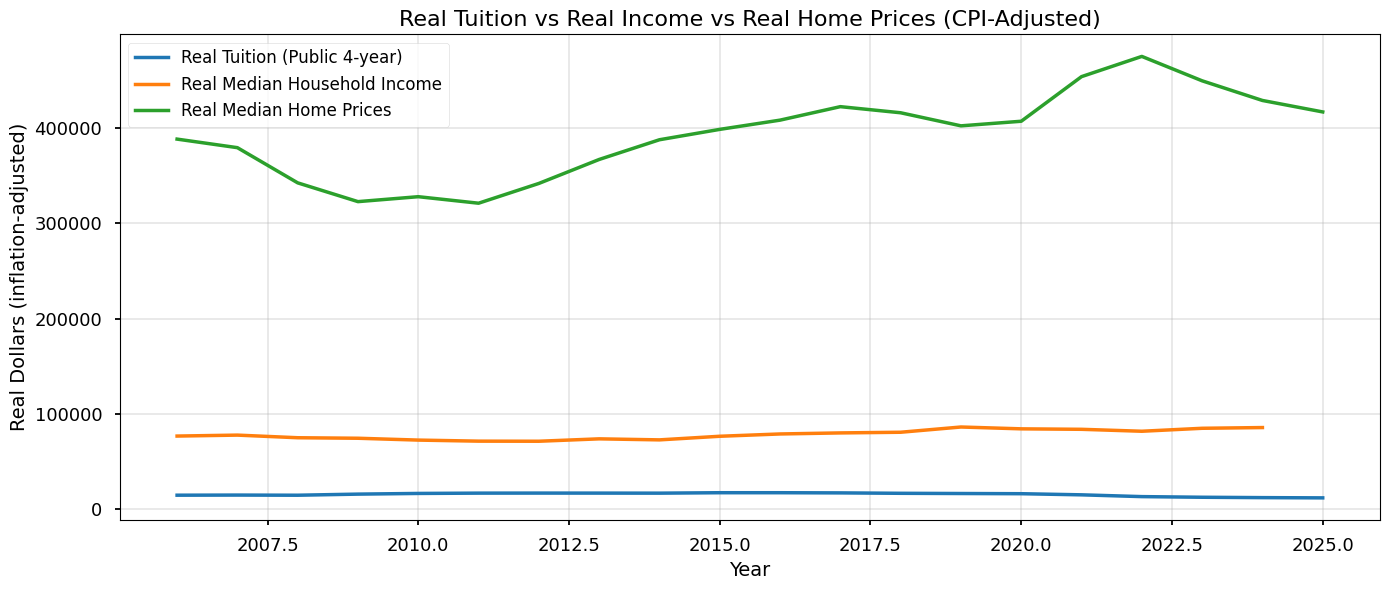

In [25]:
# ============================================================
# Historical Real Trends Plot
# Real Tuition vs Real Income vs Real Home Prices
# Using existing column names in your dataframe
# ============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(df['Year'], df['Public Four-Year_real'], label='Real Tuition (Public 4-year)', linewidth=2.5)
plt.plot(df['Year'], df['median_income_real'], label='Real Median Household Income', linewidth=2.5)
plt.plot(df['Year'], df['median_home_price_real'], label='Real Median Home Prices', linewidth=2.5)

plt.title("Real Tuition vs Real Income vs Real Home Prices (CPI-Adjusted)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Real Dollars (inflation-adjusted)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


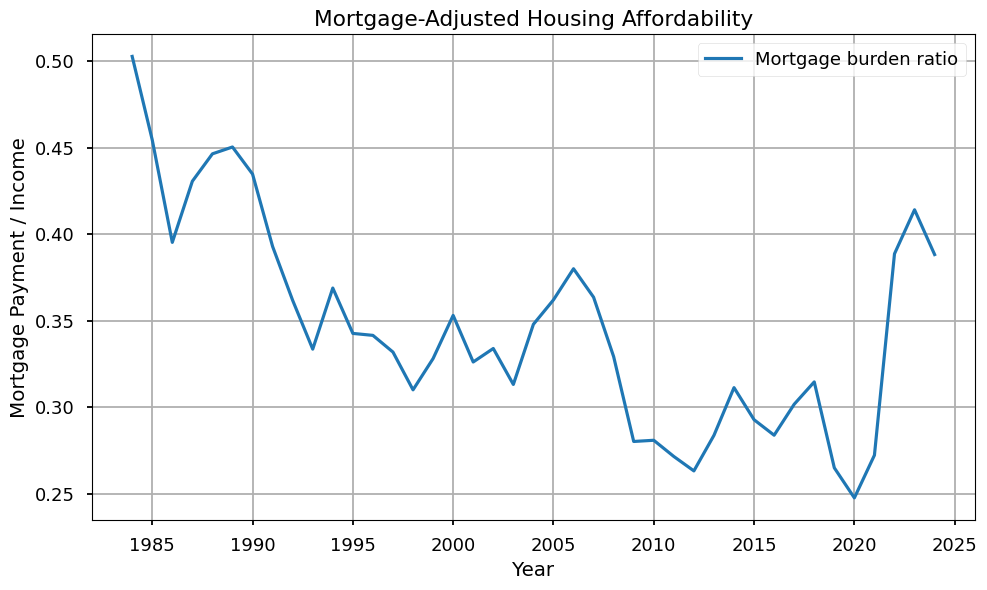

In [26]:
# === Mortgage-adjusted housing affordability ===

def mortgage_payment(principal, annual_rate, years):
    r = annual_rate / 100 / 12
    n = years * 12
    return (r * principal) / (1 - (1 + r)**(-n))

core["monthly_payment"] = mortgage_payment(
    principal=core["median_home_price_real"],
    annual_rate=core["mortgage_rate"],
    years=30
)

core["monthly_income"] = core["median_income_real"] / 12

core["mortgage_burden_ratio"] = core["monthly_payment"] / core["monthly_income"]

core[["Year", "mortgage_burden_ratio"]].head()


plt.figure()
plt.plot(core["Year"], core["mortgage_burden_ratio"], label="Mortgage burden ratio")
plt.xlabel("Year")
plt.ylabel("Mortgage Payment / Income")
plt.title("Mortgage-Adjusted Housing Affordability")
plt.legend()
plt.tight_layout()
plt.show()



In [27]:
# Assume minimum wage is $7.25 federally
MIN_WAGE = 7.25

core["hours_for_public_tuition"] = core["Public Four-Year_real"] / MIN_WAGE
core["hours_for_private_tuition"] = core["Private Nonprofit Four-Year_real"] / MIN_WAGE


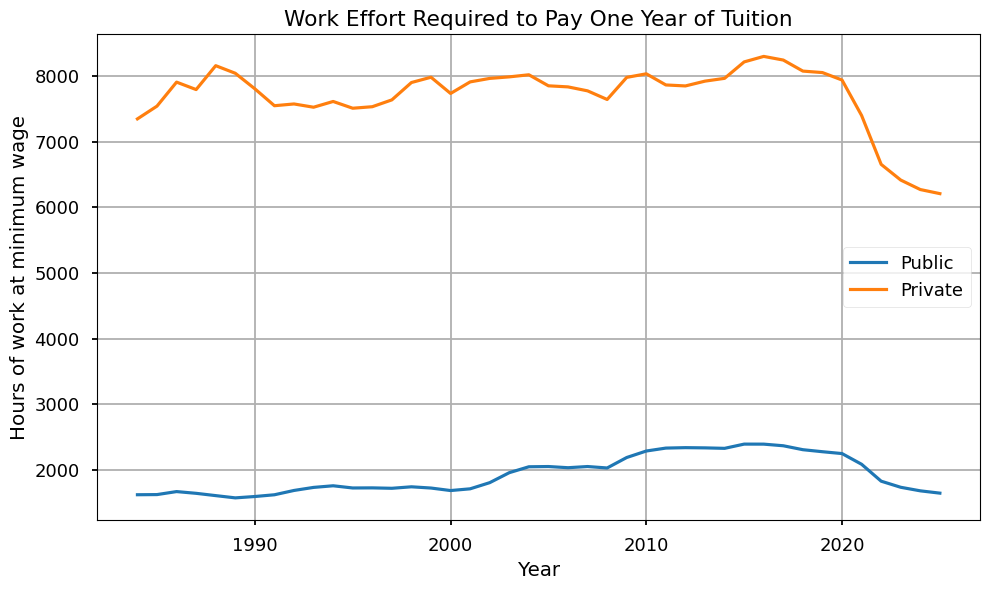

In [28]:
plt.figure()
plt.plot(core["Year"], core["hours_for_public_tuition"], label="Public")
plt.plot(core["Year"], core["hours_for_private_tuition"], label="Private")
plt.xlabel("Year")
plt.ylabel("Hours of work at minimum wage")
plt.title("Work Effort Required to Pay One Year of Tuition")
plt.legend()
plt.tight_layout()
plt.show()


## __7. Smoothing with 3-Year Rolling Averages__

In [29]:

ratio_cols_core = [
    "tuition_private_ratio_real",
    "tuition_public_ratio_real",
    "home_afford_ratio_real",
]
ratio_cols_loans = ["debt_ratio_real"]

core = add_rolling(core, ratio_cols_core, window=3)
loans = add_rolling(loans, ratio_cols_loans, window=3)

core[["Year"] + [c + "_roll" for c in ratio_cols_core]].head()


,Year,tuition_private_ratio_real_roll,tuition_public_ratio_real_roll,home_afford_ratio_real_roll
13,1984,0.771850,0.168584,3.566982
14,1985,0.776548,0.167811,3.609916
15,1986,0.775942,0.165143,3.760462
16,1987,0.784041,0.162038,3.944936
17,1988,0.781370,0.157463,4.101513


## __8. Before vs After 2000 Comparison (Real, Smoothed)__


=== 1984–1999 ===
Years: 1984 to 1999
Avg private tuition / income (real, 3y avg): 0.7689692343414807
Avg public tuition / income (real, 3y avg): 0.16721711315298704
Avg home price / income (real, 3y avg): 3.931285436067657

=== 2000–present ===
Years: 2000 to 2025
Avg private tuition / income (real, 3y avg): 0.7178711532354423
Avg public tuition / income (real, 3y avg): 0.1945968145068761
Avg home price / income (real, 3y avg): 4.872636373325637


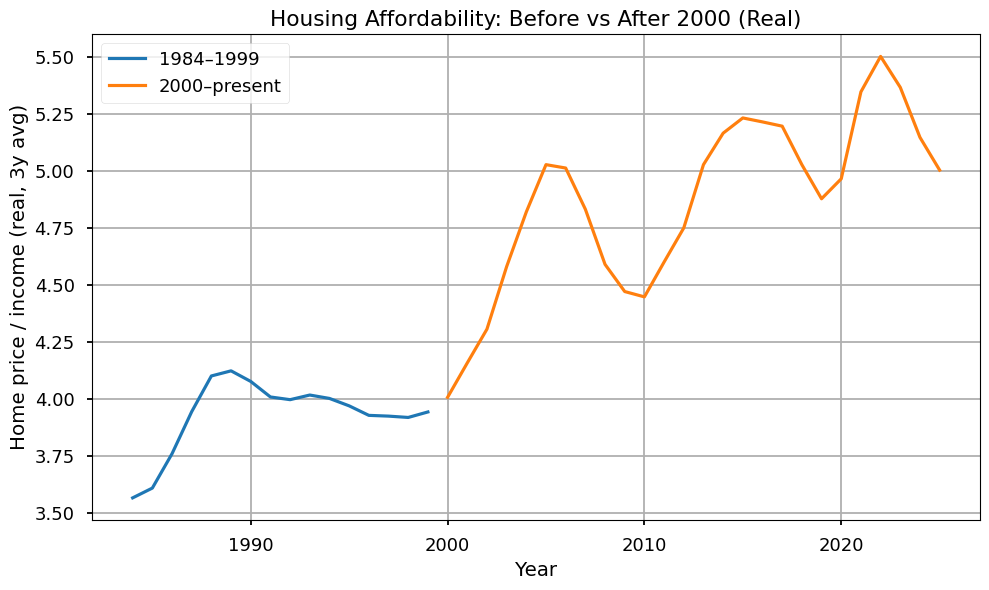

In [30]:

core_pre2000 = core[(core["Year"] >= 1984) & (core["Year"] <= 1999)]
core_post2000 = core[core["Year"] >= 2000]

segment_summary(core_pre2000, "1984–1999")
segment_summary(core_post2000, "2000–present")

# Visual comparison for housing
plt.figure()
plt.plot(core_pre2000["Year"], core_pre2000["home_afford_ratio_real_roll"],
         label="1984–1999")
plt.plot(core_post2000["Year"], core_post2000["home_afford_ratio_real_roll"],
         label="2000–present")
plt.xlabel("Year")
plt.ylabel("Home price / income (real, 3y avg)")
plt.title("Housing Affordability: Before vs After 2000 (Real)")
plt.legend()
plt.tight_layout()
plt.show()



## __9. Visualizations (Real, Smoothed Ratios)__

Tuition real ratios (smoothed)

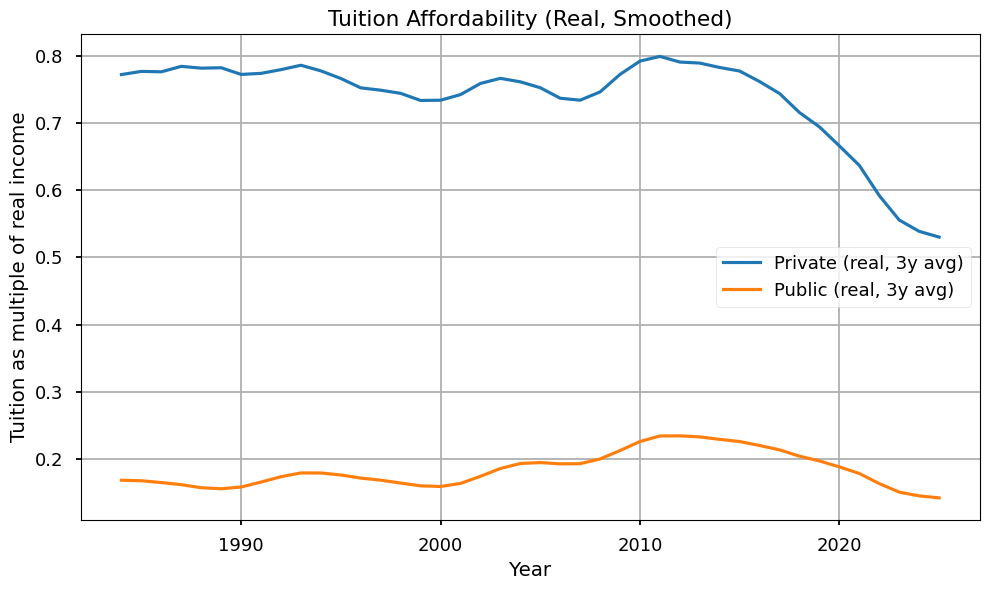

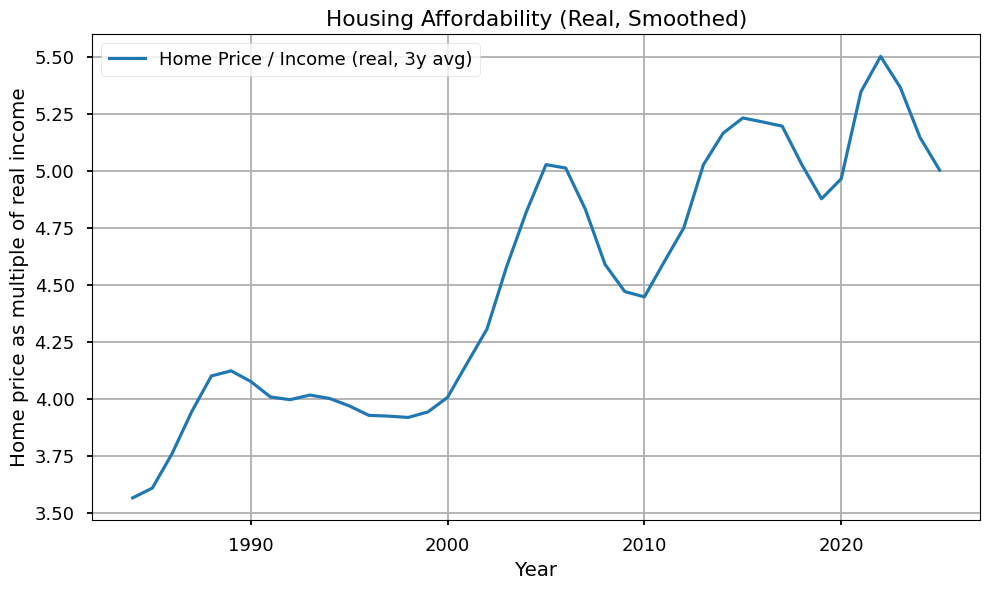

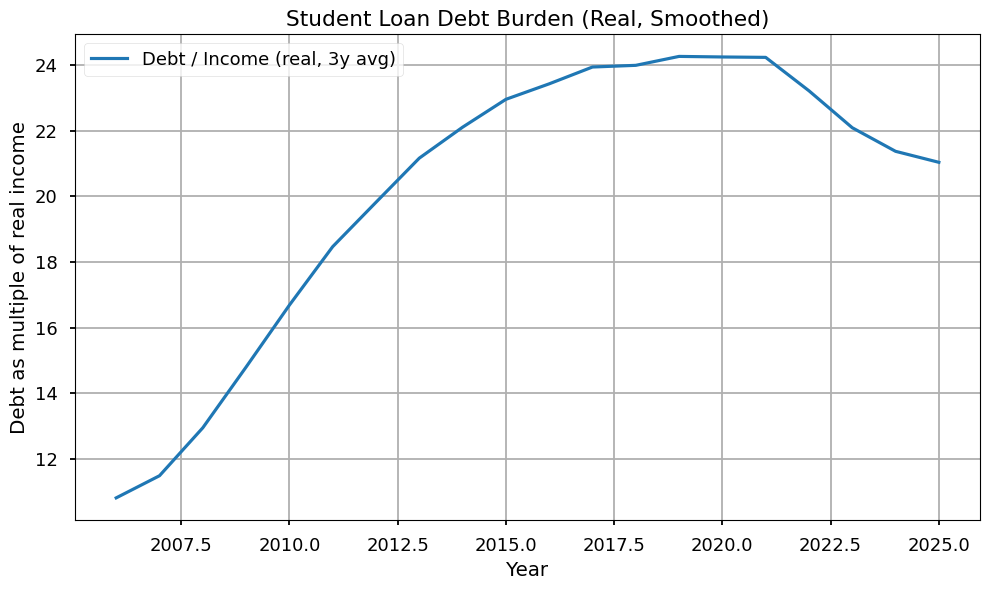

In [31]:
plt.figure()
plt.plot(core["Year"], core["tuition_private_ratio_real_roll"], label="Private (real, 3y avg)")
plt.plot(core["Year"], core["tuition_public_ratio_real_roll"], label="Public (real, 3y avg)")
plt.xlabel("Year")
plt.ylabel("Tuition as multiple of real income")
plt.title("Tuition Affordability (Real, Smoothed)")
plt.legend()
plt.tight_layout()
plt.show()

# %%
# Housing real ratio (smoothed)
plt.figure()
plt.plot(core["Year"], core["home_afford_ratio_real_roll"],
         label="Home Price / Income (real, 3y avg)")
plt.xlabel("Year")
plt.ylabel("Home price as multiple of real income")
plt.title("Housing Affordability (Real, Smoothed)")
plt.legend()
plt.tight_layout()
plt.show()

# %%
# Student debt real ratio (smoothed)
plt.figure()
plt.plot(loans["Year"], loans["debt_ratio_real_roll"],
         label="Debt / Income (real, 3y avg)")
plt.xlabel("Year")
plt.ylabel("Debt as multiple of real income")
plt.title("Student Loan Debt Burden (Real, Smoothed)")
plt.legend()
plt.tight_layout()
plt.show()


## __10. Polynomial Forecasts (Still Including COVID for Now)__

Forecast public tuition affordability (real, smoothed)



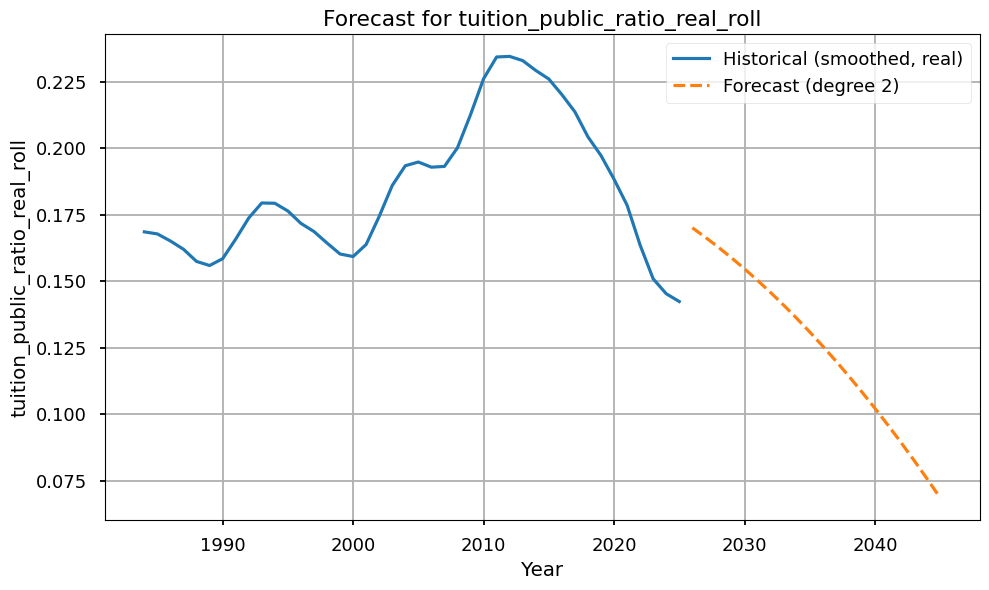

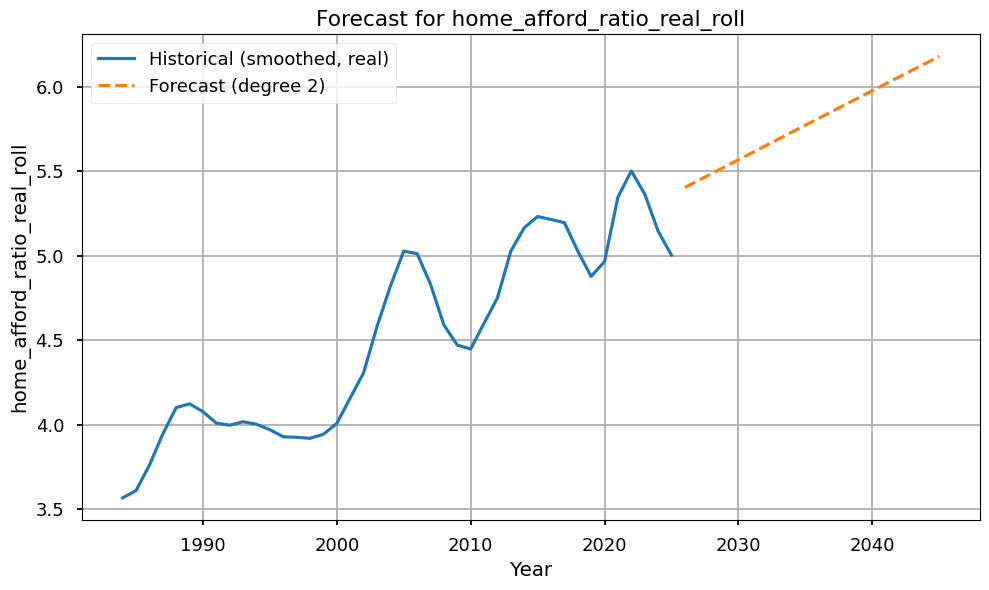

,Year,home_afford_ratio_real_roll_forecast
0,2026,5.404881
1,2027,5.445948
2,2028,5.486989
3,2029,5.528005
4,2030,5.568996


In [32]:

forecast_pub = forecast_ratio_poly(
    core,
    target_col="tuition_public_ratio_real_roll",
    horizon=20,
    degree=2,       # quadratic captures curvature better than straight line
    train_end=None  # later we can set train_end=2019 for "pre-COVID only"
)
forecast_pub.head()

# %%
# Forecast housing affordability (real, smoothed)
forecast_home = forecast_ratio_poly(
    core,
    target_col="home_afford_ratio_real_roll",
    horizon=20,
    degree=2
)
forecast_home.head()


## __11. Save Master Dataset for Further Use__

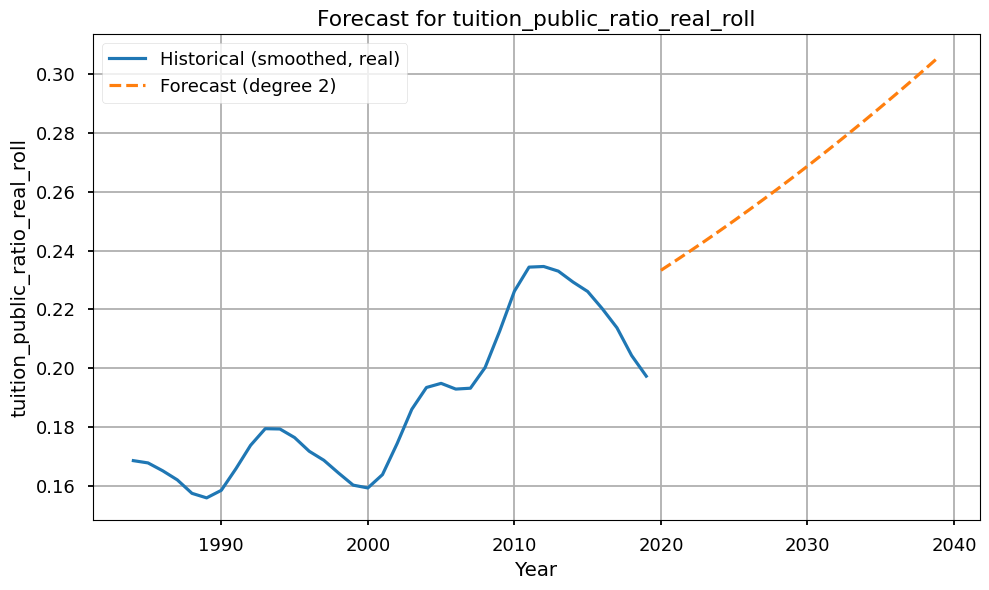

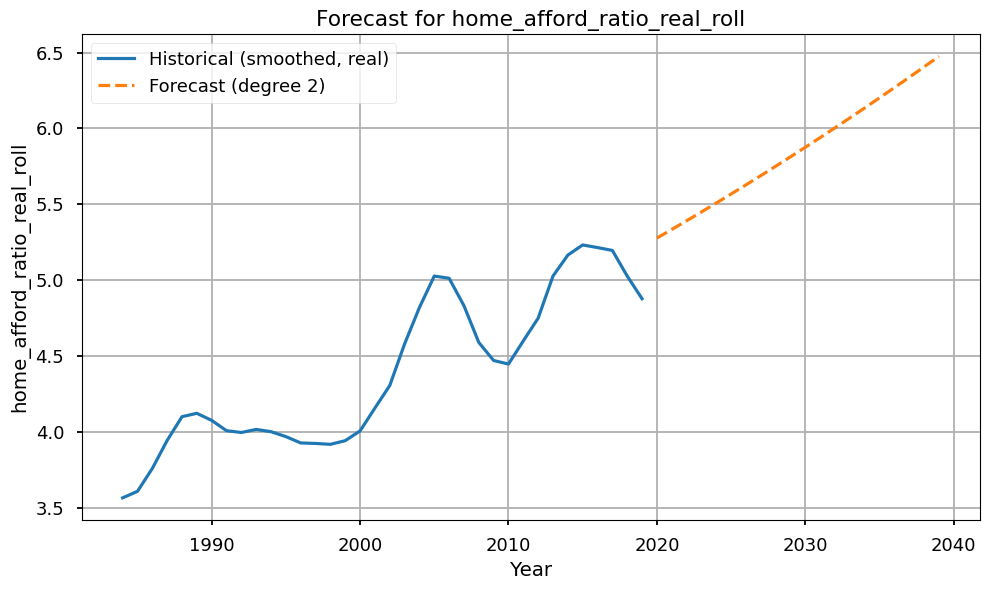

In [33]:
forecast_pub_no_covid = forecast_ratio_poly(
    core,
    target_col="tuition_public_ratio_real_roll",
    horizon=20,
    degree=2,
    train_end=2019
)


forecast_home_no_covid = forecast_ratio_poly(
    core,
    target_col="home_afford_ratio_real_roll",
    horizon=20,
    degree=2,
    train_end=2019
)


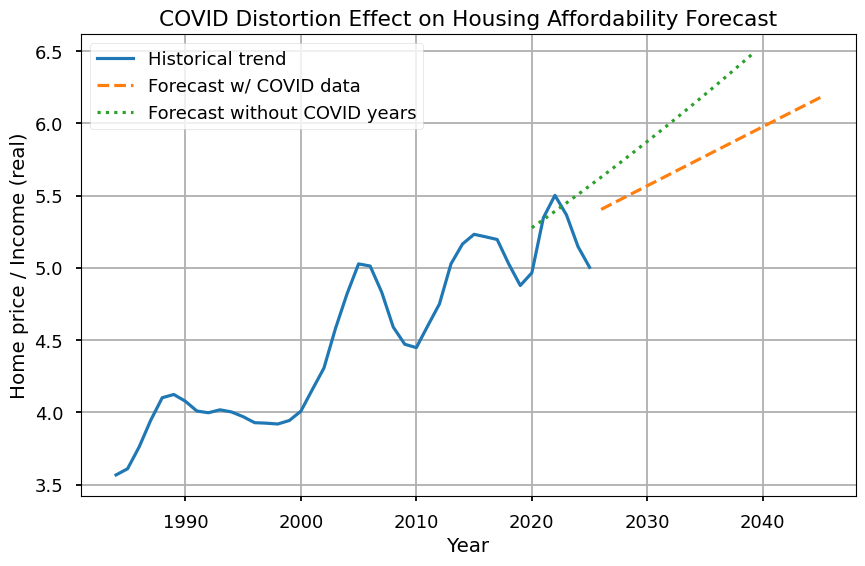

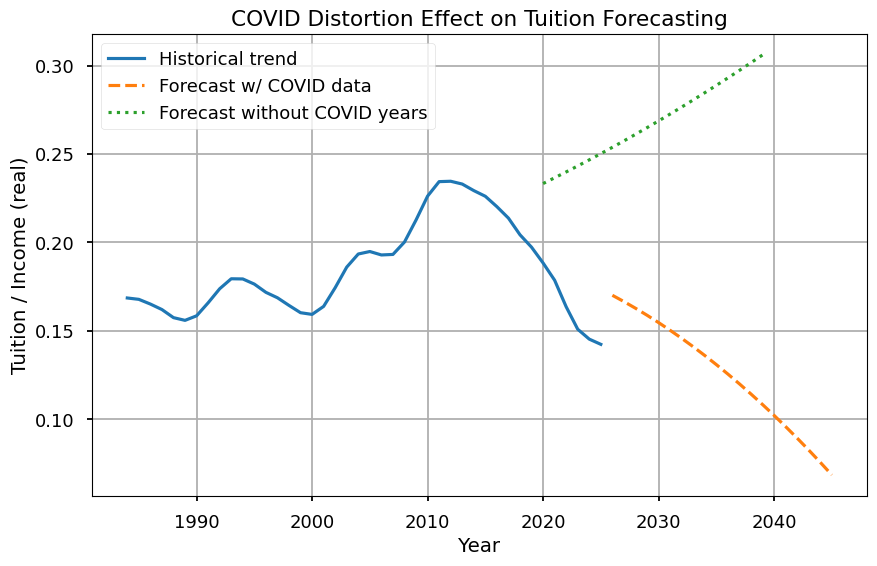

In [34]:
plt.figure()
plt.plot(core["Year"], core["home_afford_ratio_real_roll"], label="Historical trend")
plt.plot(forecast_home["Year"], forecast_home["home_afford_ratio_real_roll_forecast"],
         label="Forecast w/ COVID data", linestyle="--")
plt.plot(forecast_home_no_covid["Year"], forecast_home_no_covid["home_afford_ratio_real_roll_forecast"],
         label="Forecast without COVID years", linestyle=":")
plt.xlabel("Year")
plt.ylabel("Home price / Income (real)")
plt.title("COVID Distortion Effect on Housing Affordability Forecast")
plt.legend()
plt.show()

plt.figure()
plt.plot(core["Year"], core["tuition_public_ratio_real_roll"], label="Historical trend")
plt.plot(forecast_pub["Year"], forecast_pub["tuition_public_ratio_real_roll_forecast"],
         label="Forecast w/ COVID data", linestyle="--")
plt.plot(forecast_pub_no_covid["Year"], forecast_pub_no_covid["tuition_public_ratio_real_roll_forecast"],
         label="Forecast without COVID years", linestyle=":")
plt.xlabel("Year")
plt.ylabel("Tuition / Income (real)")
plt.title("COVID Distortion Effect on Tuition Forecasting")
plt.legend()
plt.show()



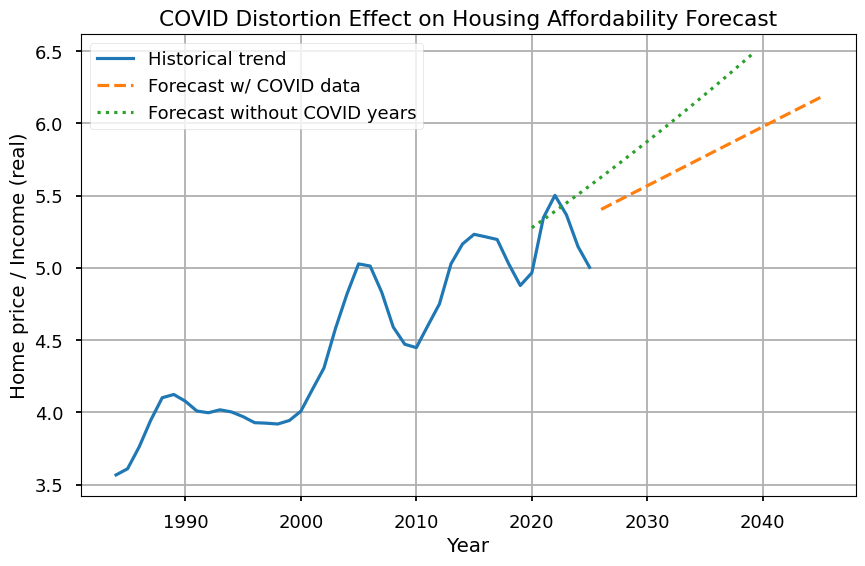

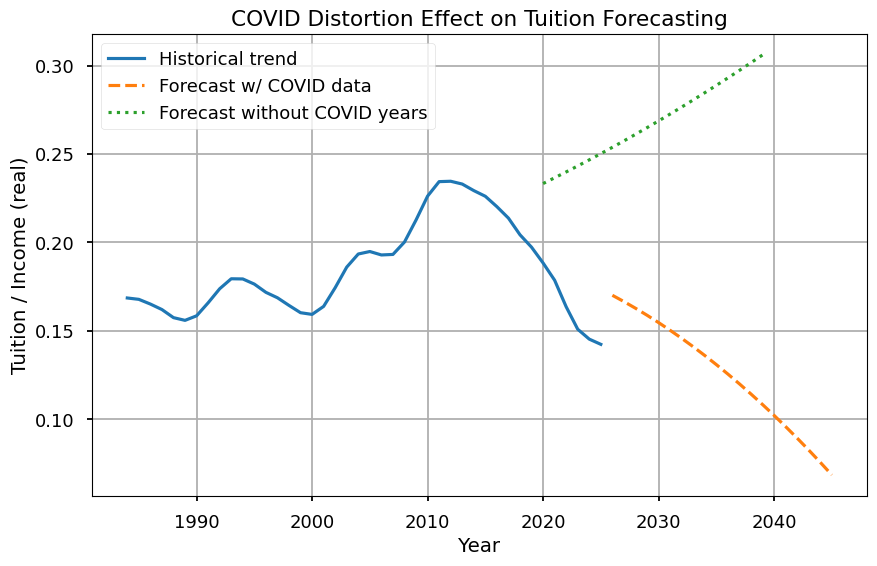

In [35]:
plt.figure()
plt.plot(core["Year"], core["home_afford_ratio_real_roll"], label="Historical trend")
plt.plot(forecast_home["Year"], forecast_home["home_afford_ratio_real_roll_forecast"],
         label="Forecast w/ COVID data", linestyle="--")
plt.plot(forecast_home_no_covid["Year"], forecast_home_no_covid["home_afford_ratio_real_roll_forecast"],
         label="Forecast without COVID years", linestyle=":")
plt.xlabel("Year")
plt.ylabel("Home price / Income (real)")
plt.title("COVID Distortion Effect on Housing Affordability Forecast")
plt.legend()
plt.show()


plt.figure()
plt.plot(core["Year"], core["tuition_public_ratio_real_roll"], label="Historical trend")
plt.plot(forecast_pub["Year"], forecast_pub["tuition_public_ratio_real_roll_forecast"],
         label="Forecast w/ COVID data", linestyle="--")
plt.plot(forecast_pub_no_covid["Year"], forecast_pub_no_covid["tuition_public_ratio_real_roll_forecast"],
         label="Forecast without COVID years", linestyle=":")
plt.xlabel("Year")
plt.ylabel("Tuition / Income (real)")
plt.title("COVID Distortion Effect on Tuition Forecasting")
plt.legend()
plt.show()


In [36]:

master.to_csv("master_affordability_dataset.csv", index=False)
print("Saved master_affordability_dataset.csv")


Saved master_affordability_dataset.csv


,Year,tuition_public_ratio_real_roll,home_afford_ratio_real_roll,roi_public_roll,dream_index
37,2021,0.178627,5.347111,5.627759,28.082774
38,2022,0.163590,5.502509,6.152340,35.306706
39,2023,0.150905,5.366758,6.646223,46.311395
40,2024,0.145303,5.147549,6.884968,54.163105
41,2025,0.142362,5.003882,7.024329,58.725996


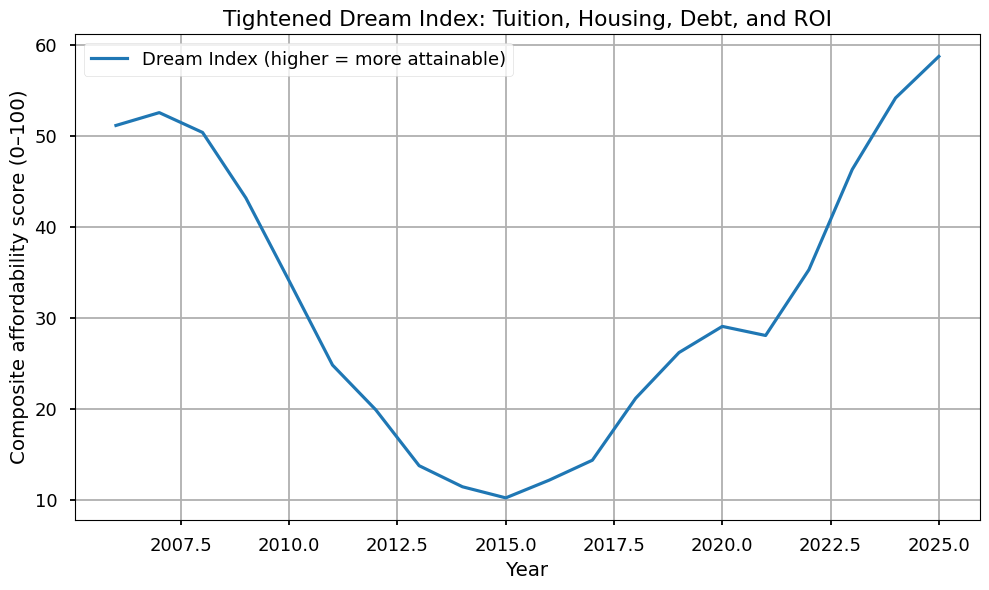


=== Fitting models for Public Tuition / Income (real, smoothed) – full (tuition_public_ratio_real_roll) ===
Training years: 1984 → 2025

=== Fitting models for Public Tuition / Income (real, smoothed) – pre-COVID only (tuition_public_ratio_real_roll) ===
Training years: 1984 → 2019

=== Fitting models for Home Price / Income (real, smoothed) – full (home_afford_ratio_real_roll) ===
Training years: 1984 → 2025

=== Fitting models for Home Price / Income (real, smoothed) – pre-COVID only (home_afford_ratio_real_roll) ===
Training years: 1984 → 2019

=== Fitting models for Student Debt / Income (real, smoothed) – full (debt_ratio_real_roll) ===
Training years: 2006 → 2025

=== Fitting models for Student Debt / Income (real, smoothed) – pre-COVID only (debt_ratio_real_roll) ===
Training years: 2006 → 2019

=== Fitting models for ROI (Income / Public Tuition, real, smoothed) – full (roi_public_roll) ===
Training years: 1984 → 2025

=== Fitting models for ROI (Income / Public Tuition, real,

/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


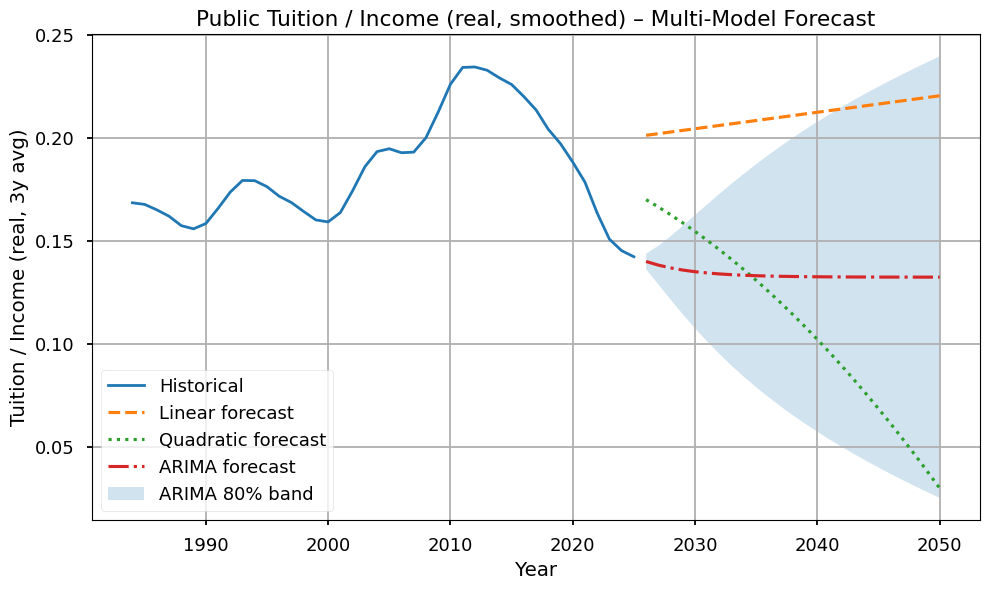

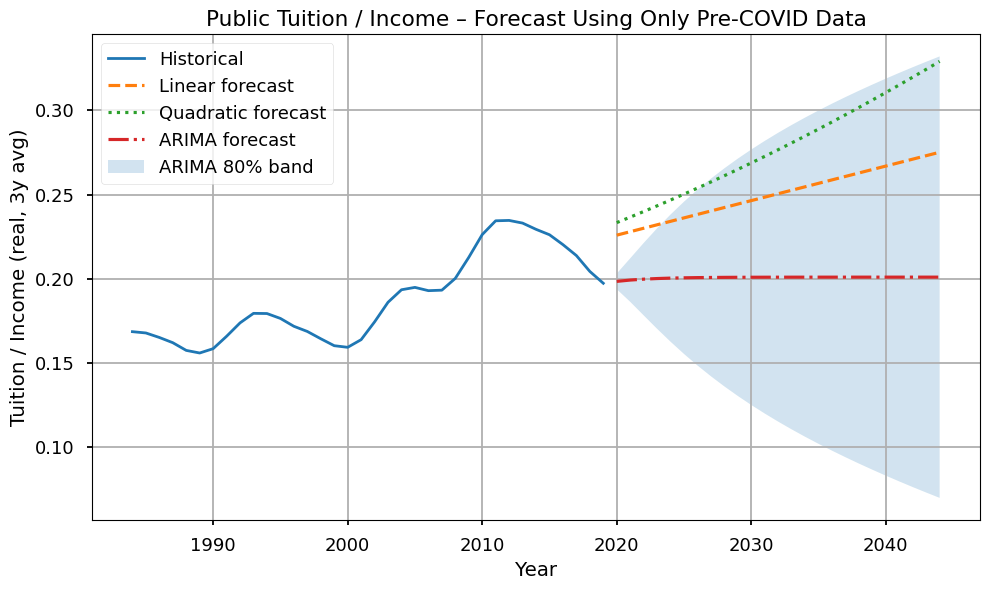

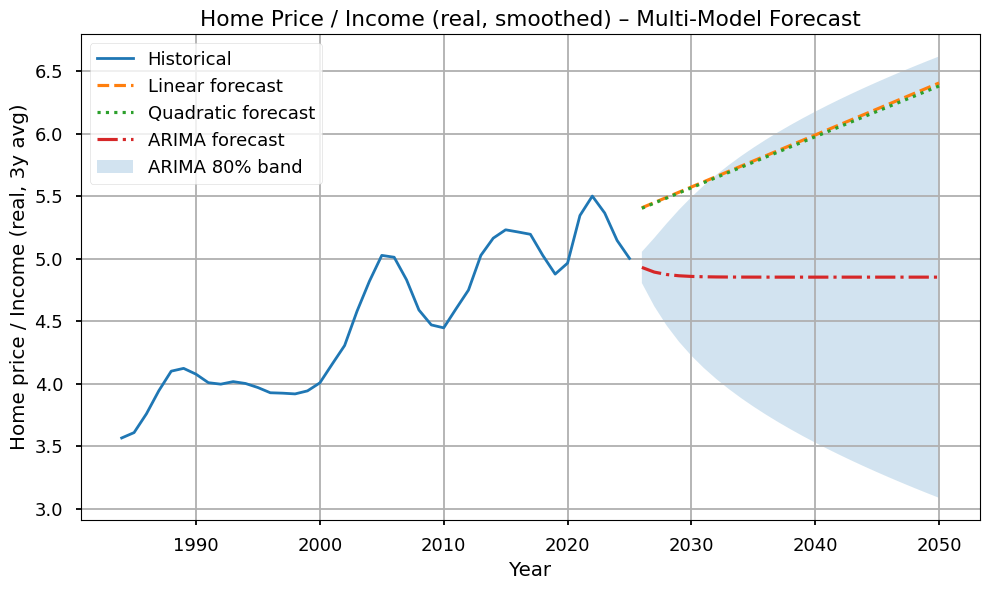

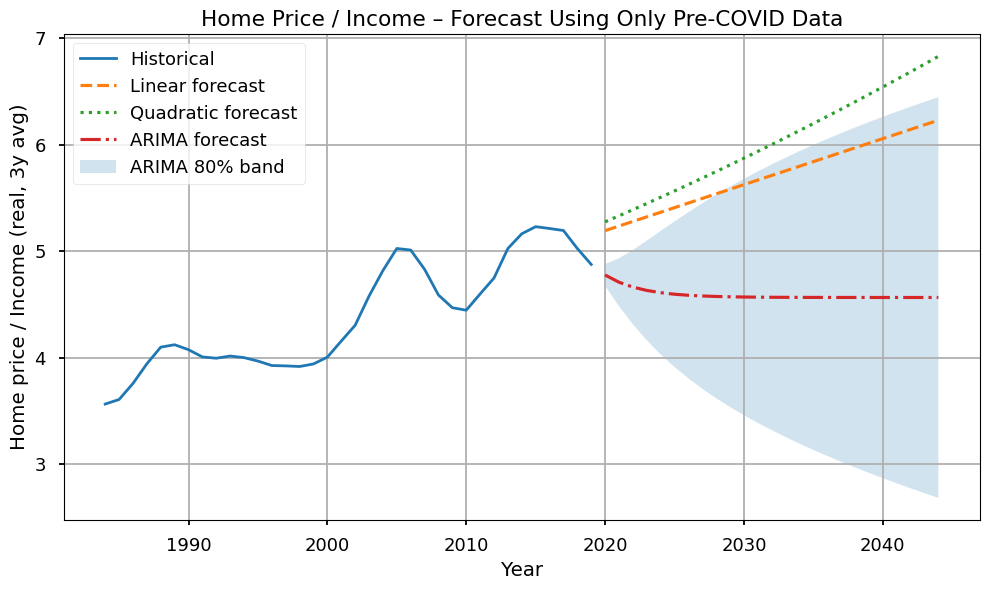

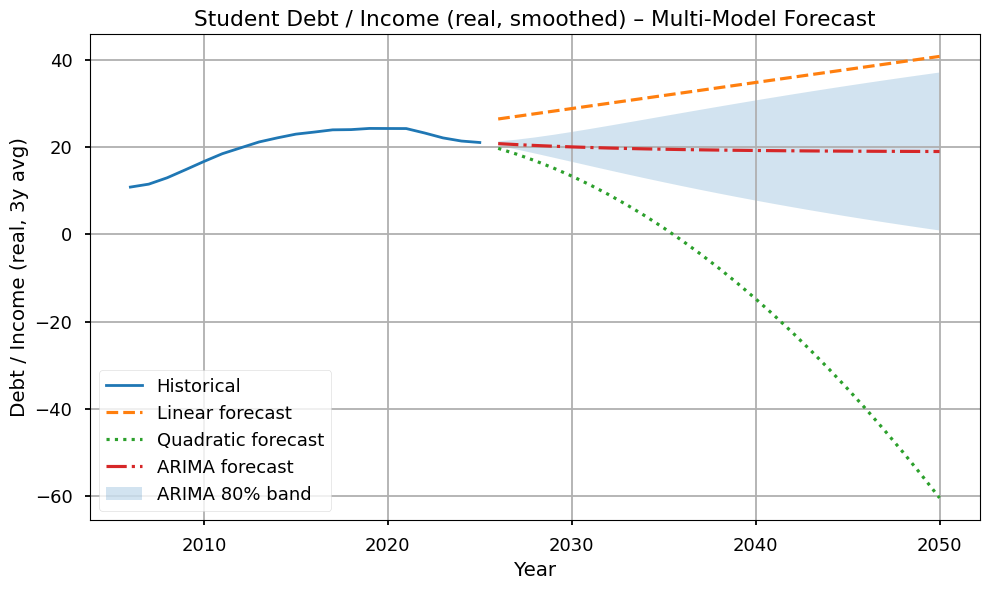

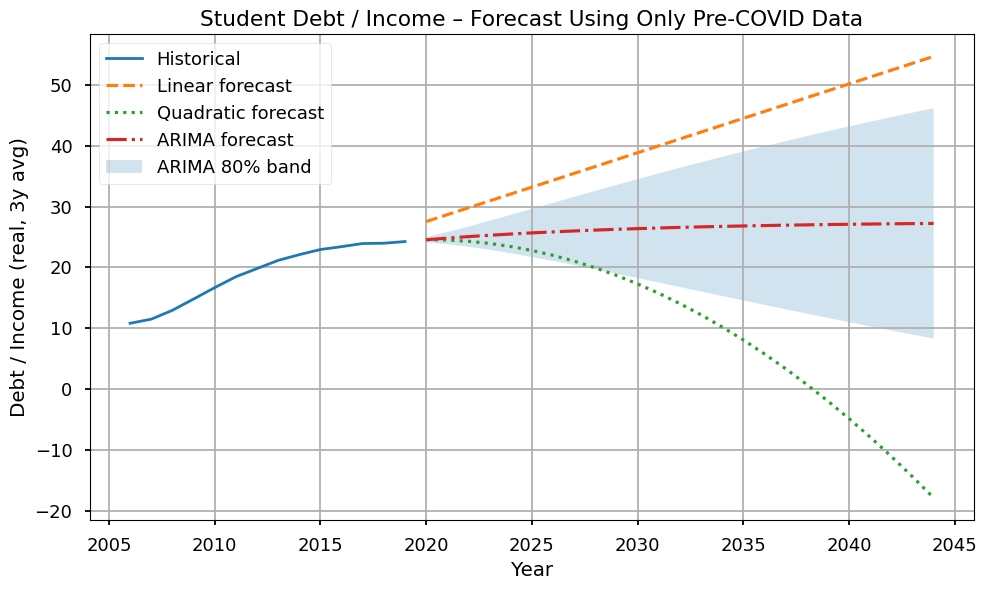

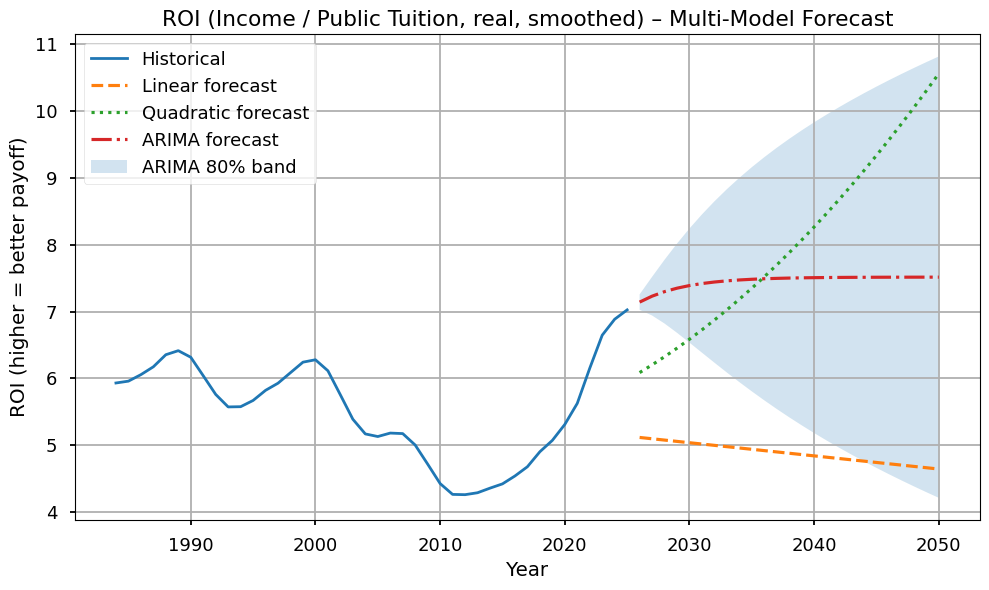

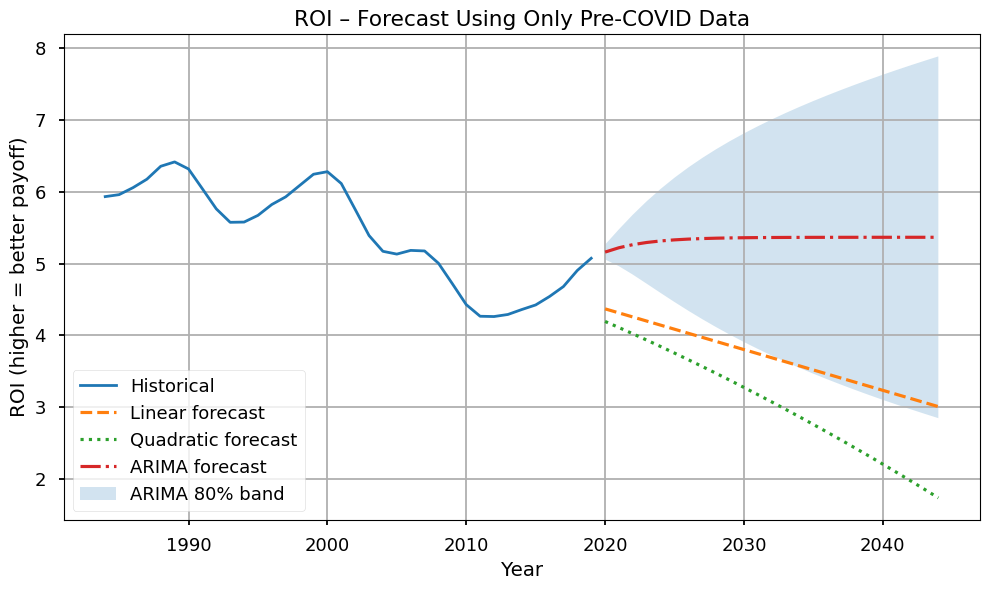

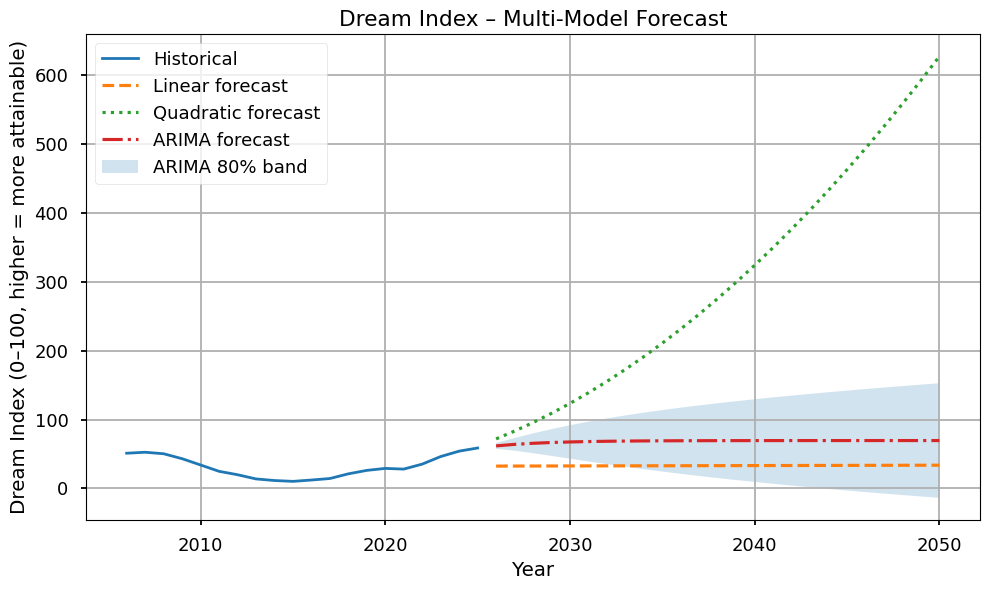

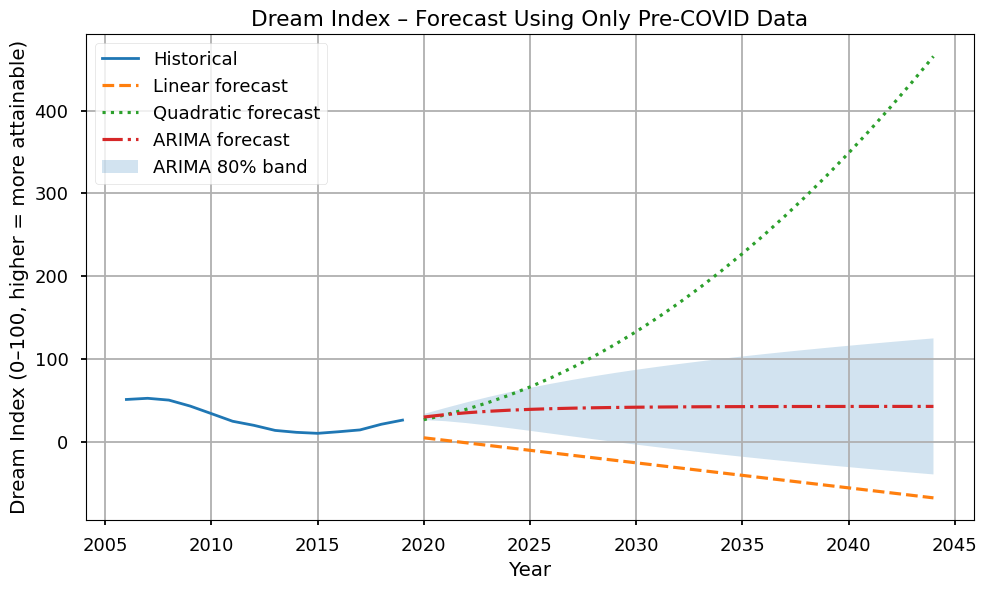

Collapse-year summary (based on illustrative thresholds):
tuition_collapse_year_full: None
tuition_collapse_year_no_covid: 2038
housing_collapse_year_full: None
housing_collapse_year_no_covid: None
debt_collapse_year_full: 2026
debt_collapse_year_no_covid: 2020
dream_collapse_year_full: None
dream_collapse_year_no_covid: 2020


In [37]:
# %% [markdown]
# ## 11. Multi-Model Forecasts, ROI, and the Dream Index
#
# This section extends the analysis with:
# - Linear, quadratic, and ARIMA forecasts for key affordability metrics
# - COVID-removed models (training only on data up to 2019)
# - A "collapse year" detector when affordability crosses chosen thresholds
# - A degree ROI proxy
# - A composite "Dream Index" summarizing overall affordability

# %%
from statsmodels.tsa.arima.model import ARIMA
# %% [markdown]
# ## 11.1 Tightened Dream Index Formula
#
# We build a composite affordability index from:
#  - Public tuition / income (real, 3-year rolling)
#  - Home price / income (real, 3-year rolling)
#  - Student debt / income (real, 3-year rolling)
#  - ROI = income / public tuition (real, 3-year rolling)
#
# Each metric is min-max scaled over its historical range, transformed to a "pain" score
# where higher means worse affordability, then combined with weights. The index is:
#   DreamIndex = 100 * (1 - Pain),
# so higher values indicate a more attainable "American Dream".

# Helper: safe min-max normalization to [0, 1]
def normalize_01(series):
    s = series.astype(float)
    s_min = s.min()
    s_max = s.max()
    if pd.isna(s_min) or pd.isna(s_max) or s_max == s_min:
        # Degenerate case: all values equal or all NaN
        return pd.Series(0.5, index=s.index)
    return (s - s_min) / (s_max - s_min)

# 1) Make sure ROI and rolling variants exist.
#    If you already computed roi_public and roi_public_roll earlier, this will just reuse them.
core["roi_public"] = core["median_income_real"] / core["Public Four-Year_real"]
core = add_rolling(core, ["roi_public"], window=3)
core.rename(columns={"roi_public_roll": "roi_public_roll"}, inplace=True)

# 2) Merge the loan-based debt ratio into core so everything lives on a single Year axis.
dream = core.merge(
    loans[["Year", "debt_ratio_real_roll"]],
    on="Year",
    how="left"
)

# 3) Build normalized "pain" metrics.
#    Higher tuition, housing, and debt → more pain.
#    Higher ROI → less pain (we convert it to a pain metric by 1 - normalized ROI).

# Tuition pain (public, real, 3-year rolling)
dream["tuition_pain"] = normalize_01(dream["tuition_public_ratio_real_roll"])

# Housing pain (home price / income, real, 3-year rolling)
dream["housing_pain"] = normalize_01(dream["home_afford_ratio_real_roll"])

# Debt pain (student loan debt / income, real, 3-year rolling)
dream["debt_pain"] = normalize_01(dream["debt_ratio_real_roll"])

# ROI: normalize as a "good" metric first (higher ROI is better),
# then convert it to pain.
roi_good_norm = normalize_01(dream["roi_public_roll"])
dream["roi_pain"] = 1.0 - roi_good_norm

# 4) Weighted pain score.
#    You can adjust these weights if you want to emphasize tuition vs housing vs debt vs ROI.
weights = {
    "tuition_pain": 0.30,
    "housing_pain": 0.30,
    "debt_pain": 0.25,
    "roi_pain": 0.15,
}

dream["dream_pain"] = (
    weights["tuition_pain"] * dream["tuition_pain"]
    + weights["housing_pain"] * dream["housing_pain"]
    + weights["debt_pain"] * dream["debt_pain"]
    + weights["roi_pain"] * dream["roi_pain"]
)

# 5) Convert pain to Dream Index on a 0–100 scale.
dream["dream_index"] = 100.0 * (1.0 - dream["dream_pain"])
dream["dream_index"] = dream["dream_index"].clip(lower=0.0, upper=100.0)

# 6) Attach back to core and loans, overwriting any previous dream_index column.
core = core.drop(columns=["dream_index"], errors="ignore").merge(
    dream[["Year", "dream_index"]],
    on="Year",
    how="left",
)

loans = loans.drop(columns=["dream_index"], errors="ignore").merge(
    dream[["Year", "dream_index"]],
    on="Year",
    how="left",
)

# Quick sanity check
display(core[["Year", "tuition_public_ratio_real_roll",
              "home_afford_ratio_real_roll",
              "roi_public_roll",
              "dream_index"]].tail())

# Plot updated Dream Index
plt.figure()
plt.plot(core["Year"], core["dream_index"], label="Dream Index (higher = more attainable)")
plt.xlabel("Year")
plt.ylabel("Composite affordability score (0–100)")
plt.title("Tightened Dream Index: Tuition, Housing, Debt, and ROI")
plt.legend()
plt.tight_layout()
plt.show()


# ------------------------------
# 11.2 General Multi-Model Forecaster
# ------------------------------

def build_all_models(
    df,
    target_col,
    horizon=25,
    train_end=None,
    arima_order=(1, 1, 1),
    label=None,
):
    """
    Fit linear, quadratic, and ARIMA models on a single time series.

    Parameters
    ----------
    df : DataFrame with 'Year' and target_col
    target_col : str
        Column to forecast (e.g. 'tuition_public_ratio_real_roll')
    horizon : int
        Number of years to forecast into the future.
    train_end : int or None
        If set, restrict training data to Year <= train_end (e.g. 2019 to remove COVID).
    arima_order : tuple
        (p, d, q) ARIMA order.
    label : str or None
        Optional label for debugging / print summaries.

    Returns
    -------
    forecast_df : DataFrame
        Columns:
            Year,
            {target}_linear,
            {target}_quadratic,
            {target}_arima,
            {target}_arima_lower,
            {target}_arima_upper
    models : dict
        Fitted model objects.
    """
    series_df = df[["Year", target_col]].dropna().copy()
    if train_end is not None:
        series_df = series_df[series_df["Year"] <= train_end]

    series_df = series_df.sort_values("Year")
    y = series_df[target_col].values
    X = series_df[["Year"]].values

    if label:
        print(f"\n=== Fitting models for {label} ({target_col}) ===")
        print("Training years:", int(series_df["Year"].min()), "→", int(series_df["Year"].max()))

    # ----- Linear regression -----
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)

    # ----- Quadratic regression -----
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    quad_reg = LinearRegression()
    quad_reg.fit(X_poly, y)

    # ----- ARIMA -----
    # Use years as a PeriodIndex with annual frequency
    idx = pd.PeriodIndex(series_df["Year"].astype(int), freq="Y")
    ts = pd.Series(y, index=idx)

    arima_model = ARIMA(ts, order=arima_order).fit()

    # ----- Forecast horizon -----
    last_year = int(series_df["Year"].max())
    future_years = np.arange(last_year + 1, last_year + 1 + horizon)
    X_future = future_years.reshape(-1, 1)

    # Linear
    y_linear = lin_reg.predict(X_future)

    # Quadratic
    X_future_poly = poly.transform(X_future)
    y_quad = quad_reg.predict(X_future_poly)

    # ARIMA (with confidence intervals)
    arima_forecast = arima_model.get_forecast(steps=horizon)
    y_arima = arima_forecast.predicted_mean.to_numpy()
    ci = arima_forecast.conf_int(alpha=0.2)  # 80% interval
    y_lower = ci.iloc[:, 0].to_numpy()
    y_upper = ci.iloc[:, 1].to_numpy()

    forecast_df = pd.DataFrame(
        {
            "Year": future_years,
            f"{target_col}_linear": y_linear,
            f"{target_col}_quadratic": y_quad,
            f"{target_col}_arima": y_arima,
            f"{target_col}_arima_lower": y_lower,
            f"{target_col}_arima_upper": y_upper,
        }
    )

    models = {
        "linear": lin_reg,
        "quadratic": quad_reg,
        "arima": arima_model,
    }

    return forecast_df, models


def plot_forecasts(history_df, target_col, forecast_df, title, ylabel, arima_band=True):
    """Helper to visualize historical series + 3 model forecasts."""
    plt.figure()
    hist = history_df[["Year", target_col]].dropna().copy()
    plt.plot(hist["Year"], hist[target_col], label="Historical", linewidth=2)

    # Linear & quadratic
    plt.plot(
        forecast_df["Year"],
        forecast_df[f"{target_col}_linear"],
        "--",
        label="Linear forecast",
    )
    plt.plot(
        forecast_df["Year"],
        forecast_df[f"{target_col}_quadratic"],
        ":",
        label="Quadratic forecast",
    )

    # ARIMA + confidence band
    if arima_band:
        plt.plot(
            forecast_df["Year"],
            forecast_df[f"{target_col}_arima"],
            "-.",
            label="ARIMA forecast",
        )
        plt.fill_between(
            forecast_df["Year"],
            forecast_df[f"{target_col}_arima_lower"],
            forecast_df[f"{target_col}_arima_upper"],
            alpha=0.2,
            label="ARIMA 80% band",
        )

    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------
# 11.3 Metrics to Model
# ------------------------------

# For each metric we build:
#  - Full-trajectory model (includes COVID years)
#  - COVID-removed model (train only on data up to 2019)

forecast_results = {}

# 1) Tuition growth: use public real ratio (smoothed)
forecast_results["tuition_full"], models_tuition_full = build_all_models(
    core,
    target_col="tuition_public_ratio_real_roll",
    horizon=25,
    train_end=None,
    arima_order=(1, 1, 1),
    label="Public Tuition / Income (real, smoothed) – full"
)

forecast_results["tuition_no_covid"], models_tuition_nc = build_all_models(
    core,
    target_col="tuition_public_ratio_real_roll",
    horizon=25,
    train_end=2019,
    arima_order=(1, 1, 1),
    label="Public Tuition / Income (real, smoothed) – pre-COVID only"
)

# 2) Housing price to income ratio (real, smoothed)
forecast_results["housing_full"], models_housing_full = build_all_models(
    core,
    target_col="home_afford_ratio_real_roll",
    horizon=25,
    train_end=None,
    arima_order=(1, 1, 1),
    label="Home Price / Income (real, smoothed) – full"
)

forecast_results["housing_no_covid"], models_housing_nc = build_all_models(
    core,
    target_col="home_afford_ratio_real_roll",
    horizon=25,
    train_end=2019,
    arima_order=(1, 1, 1),
    label="Home Price / Income (real, smoothed) – pre-COVID only"
)

# 3) Student loan burden (debt / income, real, smoothed; loans subset)
forecast_results["debt_full"], models_debt_full = build_all_models(
    loans,
    target_col="debt_ratio_real_roll",
    horizon=25,
    train_end=None,
    arima_order=(1, 1, 1),
    label="Student Debt / Income (real, smoothed) – full"
)

forecast_results["debt_no_covid"], models_debt_nc = build_all_models(
    loans,
    target_col="debt_ratio_real_roll",
    horizon=25,
    train_end=2019,
    arima_order=(1, 1, 1),
    label="Student Debt / Income (real, smoothed) – pre-COVID only"
)

# 4) ROI for degree (use public ROI, smoothed)
forecast_results["roi_full"], models_roi_full = build_all_models(
    core,
    target_col="roi_public_roll",
    horizon=25,
    train_end=None,
    arima_order=(1, 1, 1),
    label="ROI (Income / Public Tuition, real, smoothed) – full"
)

forecast_results["roi_no_covid"], models_roi_nc = build_all_models(
    core,
    target_col="roi_public_roll",
    horizon=25,
    train_end=2019,
    arima_order=(1, 1, 1),
    label="ROI (Income / Public Tuition, real, smoothed) – pre-COVID only"
)

# 5) Dream Index itself
forecast_results["dream_full"], models_dream_full = build_all_models(
    core,
    target_col="dream_index",
    horizon=25,
    train_end=None,
    arima_order=(1, 1, 1),
    label="Dream Index – full"
)

forecast_results["dream_no_covid"], models_dream_nc = build_all_models(
    core,
    target_col="dream_index",
    horizon=25,
    train_end=2019,
    arima_order=(1, 1, 1),
    label="Dream Index – pre-COVID only"
)


# ------------------------------
# 11.4 Visualization of Each Metric
# ------------------------------

# Tuition
plot_forecasts(
    core,
    target_col="tuition_public_ratio_real_roll",
    forecast_df=forecast_results["tuition_full"],
    title="Public Tuition / Income (real, smoothed) – Multi-Model Forecast",
    ylabel="Tuition / Income (real, 3y avg)"
)

plot_forecasts(
    core[core["Year"] <= 2019],
    target_col="tuition_public_ratio_real_roll",
    forecast_df=forecast_results["tuition_no_covid"],
    title="Public Tuition / Income – Forecast Using Only Pre-COVID Data",
    ylabel="Tuition / Income (real, 3y avg)"
)

# Housing
plot_forecasts(
    core,
    target_col="home_afford_ratio_real_roll",
    forecast_df=forecast_results["housing_full"],
    title="Home Price / Income (real, smoothed) – Multi-Model Forecast",
    ylabel="Home price / Income (real, 3y avg)"
)

plot_forecasts(
    core[core["Year"] <= 2019],
    target_col="home_afford_ratio_real_roll",
    forecast_df=forecast_results["housing_no_covid"],
    title="Home Price / Income – Forecast Using Only Pre-COVID Data",
    ylabel="Home price / Income (real, 3y avg)"
)

# Student debt
plot_forecasts(
    loans,
    target_col="debt_ratio_real_roll",
    forecast_df=forecast_results["debt_full"],
    title="Student Debt / Income (real, smoothed) – Multi-Model Forecast",
    ylabel="Debt / Income (real, 3y avg)"
)

plot_forecasts(
    loans[loans["Year"] <= 2019],
    target_col="debt_ratio_real_roll",
    forecast_df=forecast_results["debt_no_covid"],
    title="Student Debt / Income – Forecast Using Only Pre-COVID Data",
    ylabel="Debt / Income (real, 3y avg)"
)

# ROI
plot_forecasts(
    core,
    target_col="roi_public_roll",
    forecast_df=forecast_results["roi_full"],
    title="ROI (Income / Public Tuition, real, smoothed) – Multi-Model Forecast",
    ylabel="ROI (higher = better payoff)"
)

plot_forecasts(
    core[core["Year"] <= 2019],
    target_col="roi_public_roll",
    forecast_df=forecast_results["roi_no_covid"],
    title="ROI – Forecast Using Only Pre-COVID Data",
    ylabel="ROI (higher = better payoff)"
)

# Dream Index
plot_forecasts(
    core,
    target_col="dream_index",
    forecast_df=forecast_results["dream_full"],
    title="Dream Index – Multi-Model Forecast",
    ylabel="Dream Index (0–100, higher = more attainable)"
)

plot_forecasts(
    core[core["Year"] <= 2019],
    target_col="dream_index",
    forecast_df=forecast_results["dream_no_covid"],
    title="Dream Index – Forecast Using Only Pre-COVID Data",
    ylabel="Dream Index (0–100, higher = more attainable)"
)


# ------------------------------
# 11.5 Collapse-Year Detection Utilities
# ------------------------------

def find_collapse_year(forecast_df, col, threshold, direction="above"):
    """
    Find the first forecast year where a metric crosses a given threshold.

    direction = "above"  → first year where value >= threshold
    direction = "below"  → first year where value <= threshold
    """
    if direction == "above":
        mask = forecast_df[col] >= threshold
    else:
        mask = forecast_df[col] <= threshold

    if not mask.any():
        return None

    return int(forecast_df.loc[mask, "Year"].iloc[0])


# Example: user-tunable thresholds.
# These are illustrative starting points; tune them based on your narrative:
collapse_thresholds = {
    "tuition_public_ratio_real_roll": 0.30,  # tuition is 30% of median income
    "home_afford_ratio_real_roll": 7.0,      # home costs 7x median income
    "debt_ratio_real_roll": 1.0,             # debt equals 1x median income
    "dream_index": 60.0,                     # below 30 → American Dream effectively "collapsed"
}

collapse_summary = {
    "tuition_collapse_year_full": find_collapse_year(
        forecast_results["tuition_full"],
        col="tuition_public_ratio_real_roll_quadratic",
        threshold=collapse_thresholds["tuition_public_ratio_real_roll"],
        direction="above",
    ),
    "tuition_collapse_year_no_covid": find_collapse_year(
        forecast_results["tuition_no_covid"],
        col="tuition_public_ratio_real_roll_quadratic",
        threshold=collapse_thresholds["tuition_public_ratio_real_roll"],
        direction="above",
    ),
    "housing_collapse_year_full": find_collapse_year(
        forecast_results["housing_full"],
        col="home_afford_ratio_real_roll_quadratic",
        threshold=collapse_thresholds["home_afford_ratio_real_roll"],
        direction="above",
    ),
    "housing_collapse_year_no_covid": find_collapse_year(
        forecast_results["housing_no_covid"],
        col="home_afford_ratio_real_roll_quadratic",
        threshold=collapse_thresholds["home_afford_ratio_real_roll"],
        direction="above",
    ),
    "debt_collapse_year_full": find_collapse_year(
        forecast_results["debt_full"],
        col="debt_ratio_real_roll_quadratic",
        threshold=collapse_thresholds["debt_ratio_real_roll"],
        direction="above",
    ),
    "debt_collapse_year_no_covid": find_collapse_year(
        forecast_results["debt_no_covid"],
        col="debt_ratio_real_roll_quadratic",
        threshold=collapse_thresholds["debt_ratio_real_roll"],
        direction="above",
    ),
    "dream_collapse_year_full": find_collapse_year(
        forecast_results["dream_full"],
        col="dream_index_quadratic",
        threshold=collapse_thresholds["dream_index"],
        direction="below",
    ),
    "dream_collapse_year_no_covid": find_collapse_year(
        forecast_results["dream_no_covid"],
        col="dream_index_quadratic",
        threshold=collapse_thresholds["dream_index"],
        direction="below",
    ),
}

print("Collapse-year summary (based on illustrative thresholds):")
for k, v in collapse_summary.items():
    print(f"{k}: {v}")


 ### 11.2 Thresholds for When the American Dream "Collapses"

To convert the raw affordability ratios into a concrete notion of when the
 American Dream effectively "breaks," we adopt three standard, research-based
 thresholds:

 - **Mortgage burden threshold (30%)**  
   We set `DREAM_MORTGAGE_CUTOFF = 0.30`. When the modeled 30-year mortgage
   payment exceeds **30% of gross household income**, housing is considered
   unaffordable for the median household (consistent with HUD and NAR
   affordability guidelines).

 - **Degree ROI threshold (≤ 0)**  
   We proxy the ROI of a public 4-year degree via  
   \( \text{degree\_roi\_public} \approx \text{roi\_public\_roll} - 1 \),  
   where `roi_public_roll` is (median income / public tuition), smoothed.  
   When **degree_roi_public ≤ 0**, annual income is no longer greater than one
   year of public tuition — the degree no longer clearly "pays for itself."

 - **Dream Index threshold (score < 60)**  
   The composite **Dream Index** rescales multiple affordability metrics to a
   0–100 scale, where higher is better. Following the interpretation of many
   composite well-being and affordability indices, we treat:
   - 80–100 as healthy  
   - 60–80 as strained  
   - **< 60 as a structural breakdown**

   Accordingly, we declare the American Dream to be **"collapsed"** once the
   Dream Index forecast falls **below 60** and stays there.

These thresholds make the collapse-year diagnostics interpretable: when college
 no longer offers clear financial upside *and* housing breaches the 30% burden
 line, or when the Dream Index falls below 60, the "go to college, then buy a
 house" pathway is no longer realistically attainable for the median household.


In [38]:
# %% [markdown]
# # 11.X TensorFlow Neural Forecasting Model (Dense Neural Network)
#
# This section adds a 4th forecasting method: a deep-learning-based Dense Neural Network (DNN).
# Unlike ARIMA, which only models short-run inertia, the neural model can learn nonlinear
# affordability curvature for medium-range forecasts. Works well with small datasets.

import tensorflow as tf
import keras
from keras import layers, models, callbacks, optimizers



# ------------------------------
# 1. Build a neural forecasting model
# ------------------------------

def build_tf_neural_model():
    """
    A small feed-forward neural network that can approximate nonlinear trend curves.
    Works well on small economic time series.
    """
    model = models.Sequential([
        layers.Dense(64, activation="relu", input_shape=(1,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss="mse"
    )
    return model


# ------------------------------
# 2. Neural forecast wrapper
# ------------------------------

def neural_forecast(df, target_col, horizon=25, train_end=None, epochs=300):
    """
    Fit a neural model (Dense DNN) to learn nonlinear affordability curves.

    Parameters
    ----------
    df : DataFrame
        Must contain "Year" and target_col
    target_col : str
        Column to forecast (e.g. 'tuition_public_ratio_real_roll')
    horizon : int
        Years to forecast
    train_end : int or None
        Restrict training to Year <= train_end (for COVID-removed models)
    epochs : int
        Training epochs for the neural network

    Returns
    -------
    forecast_df : DataFrame
        Neural predictions for each future year
    model : fitted neural network
    history : training loss history
    """

    # Filter and clean
    series_df = df[["Year", target_col]].dropna().copy()
    if train_end is not None:
        series_df = series_df[series_df["Year"] <= train_end]

    series_df = series_df.sort_values("Year")
    X = series_df["Year"].values.reshape(-1, 1)
    y = series_df[target_col].values.reshape(-1, 1)

    # Normalize years for stability
    year_min = X.min()
    year_max = X.max()
    X_norm = (X - year_min) / (year_max - year_min)

    # Build neural model
    model = build_tf_neural_model()

    # Early stopping to avoid overfitting
    es = callbacks.EarlyStopping(
        patience=50,
        restore_best_weights=True,
        monitor="loss"
    )

    # Train neural network
    history = model.fit(
        X_norm, y,
        epochs=epochs,
        verbose=0,
        callbacks=[es]
    )

    # Prepare future years
    last_year = int(series_df["Year"].max())
    future_years = np.arange(last_year + 1, last_year + 1 + horizon)
    X_future = future_years.reshape(-1, 1)
    X_future_norm = (X_future - year_min) / (year_max - year_min)

    # Predict
    y_pred = model.predict(X_future_norm).flatten()

    # Return forecast
    forecast_df = pd.DataFrame({
        "Year": future_years,
        f"{target_col}_neural": y_pred
    })

    return forecast_df, model, history


# ------------------------------
# 3. Neural training-loss plot
# ------------------------------

def plot_nn_training(history, title):
    plt.figure()
    plt.plot(history.history["loss"], label="Training Loss")
    plt.title(f"{title} – Neural Model Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------
# 4. Integrate neural forecasts for ALL METRICS
# ------------------------------

neural_forecasts = {}

metrics_to_model = {
    "tuition_public_ratio_real_roll": core,
    "home_afford_ratio_real_roll": core,
    "debt_ratio_real_roll": loans,
    "roi_public_roll": core,
    "dream_index": core,
}

for metric, df_src in metrics_to_model.items():
    print(f"\n=== Training Neural Forecast for {metric} ===")

    # Full model (with COVID)
    nf_full, nn_model_full, hist_full = neural_forecast(
        df_src,
        target_col=metric,
        horizon=25,
        train_end=None
    )

    # COVID-removed model (train through 2019)
    nf_nc, nn_model_nc, hist_nc = neural_forecast(
        df_src,
        target_col=metric,
        horizon=25,
        train_end=2019
    )

    neural_forecasts[f"{metric}_full"] = {
        "forecast_df": nf_full,
        "model": nn_model_full,
        "history": hist_full
    }
    neural_forecasts[f"{metric}_no_covid"] = {
        "forecast_df": nf_nc,
        "model": nn_model_nc,
        "history": hist_nc
    }

print("\nNeural forecasts stored in neural_forecasts[] dictionary.")


# ------------------------------
# 5. Update plot_forecasts() to include neural line
# ------------------------------

def plot_forecasts(
    history_df,
    target_col,
    forecast_df,
    title,
    ylabel,
    arima_band=True,
    caption=None,
    good_direction=None
):
    plt.figure()
    hist = history_df[["Year", target_col]].dropna()
    plt.plot(hist["Year"], hist[target_col], label="Historical", linewidth=2)

    # Linear
    if f"{target_col}_linear" in forecast_df.columns:
        plt.plot(forecast_df["Year"], forecast_df[f"{target_col}_linear"],
                 "--", label="Linear forecast")

    # Quadratic
    if f"{target_col}_quadratic" in forecast_df.columns:
        plt.plot(forecast_df["Year"], forecast_df[f"{target_col}_quadratic"],
                 ":", label="Quadratic forecast")

    # ARIMA
    if arima_band and f"{target_col}_arima" in forecast_df.columns:
        plt.plot(forecast_df["Year"], forecast_df[f"{target_col}_arima"],
                 "-.", label="ARIMA forecast")
        if (f"{target_col}_arima_lower" in forecast_df.columns and
            f"{target_col}_arima_upper" in forecast_df.columns):
            plt.fill_between(
                forecast_df["Year"],
                forecast_df[f"{target_col}_arima_lower"],
                forecast_df[f"{target_col}_arima_upper"],
                alpha=0.2,
                label="ARIMA 80% band"
            )

    # Neural Forecast
    if f"{target_col}_neural" in forecast_df.columns:
        plt.plot(
            forecast_df["Year"],
            forecast_df[f"{target_col}_neural"],
            color="magenta",
            linewidth=2,
            label="Neural (DNN) forecast"
        )

    # Subtitle with "good direction" arrow
    if good_direction == "up":
        plt.suptitle(title + "\n(↑ higher is better)", fontsize=11)
    elif good_direction == "down":
        plt.suptitle(title + "\n(↓ lower is better)", fontsize=11)
    else:
        plt.title(title)

    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()

    if caption:
        plt.figtext(
            0.5, -0.08, caption,
            ha='center', fontsize=10, wrap=True
        )

    plt.show()

print("TensorFlow integration complete.")



=== Training Neural Forecast for tuition_public_ratio_real_roll ===


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

=== Training Neural Forecast for home_afford_ratio_real_roll ===


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

=== Training Neural Forecast for debt_ratio_real_roll ===


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

=== Training Neural Forecast for roi_public_roll ===


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

=== Training Neural Forecast for dream_index ===


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Neural forecasts stored in neural_forecasts[] dictionary.
TensorFlow integration complete.


In [39]:
def add_chart_caption(text):
    plt.figtext(
        0.5,    # centered horizontally
        -0.08,  # placed slightly below bottom
        text,
        wrap=True,
        horizontalalignment='center',
        fontsize=10
    )


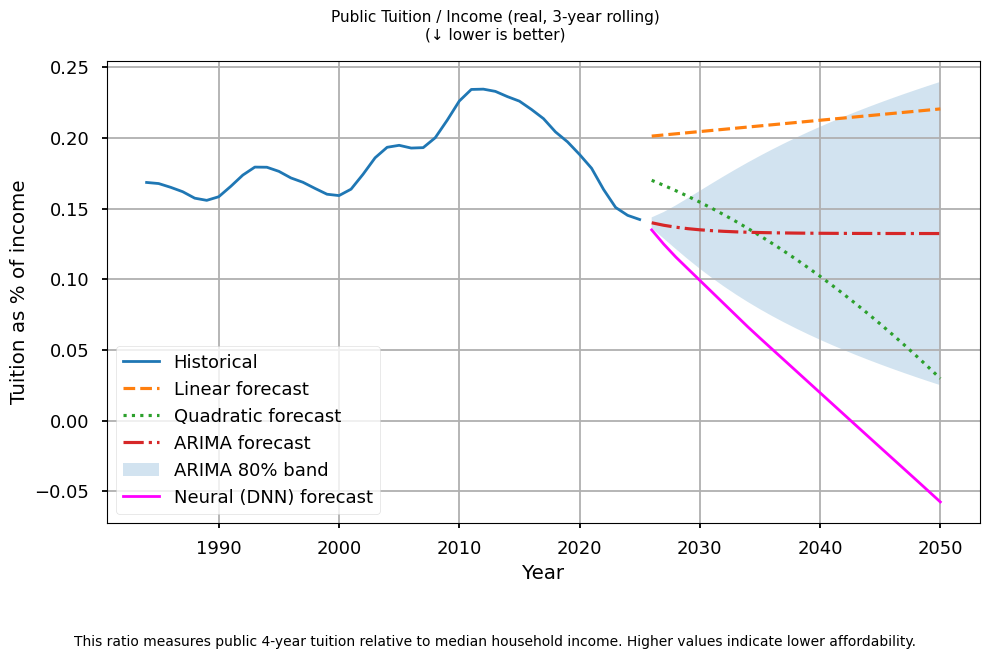

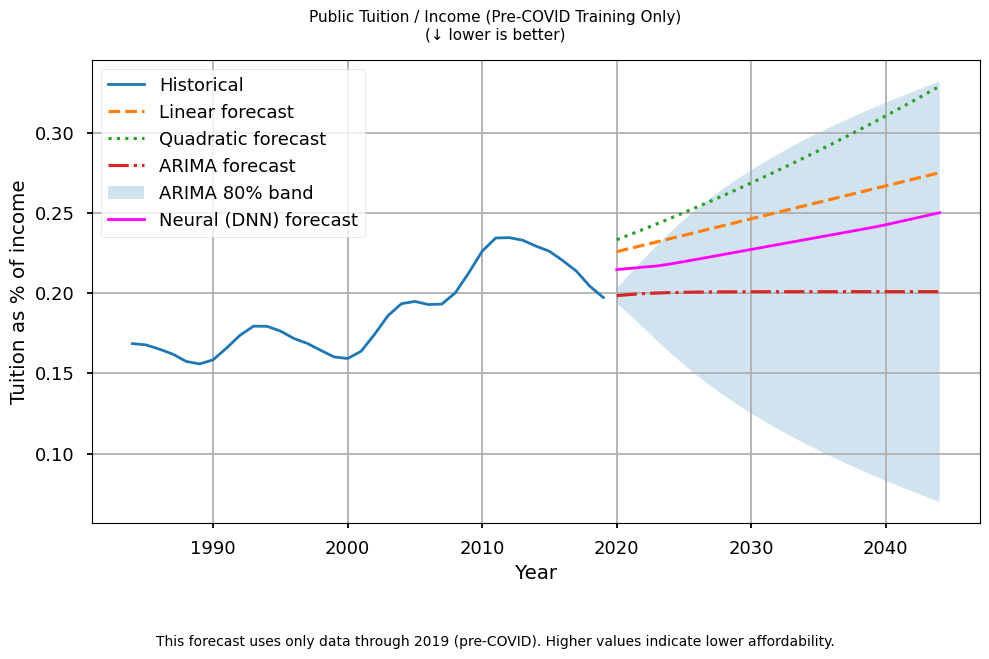

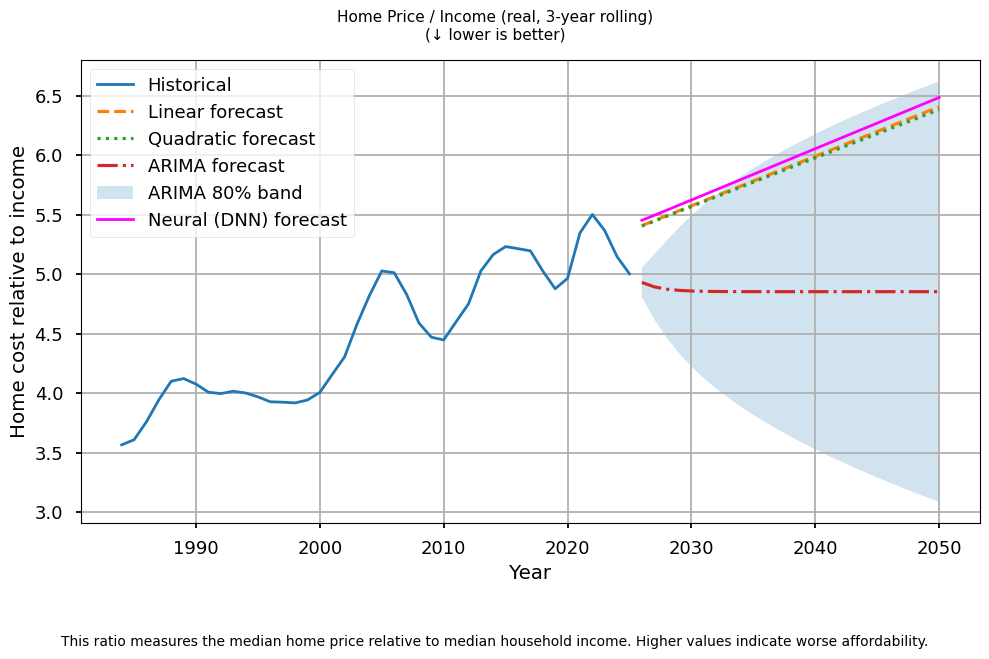

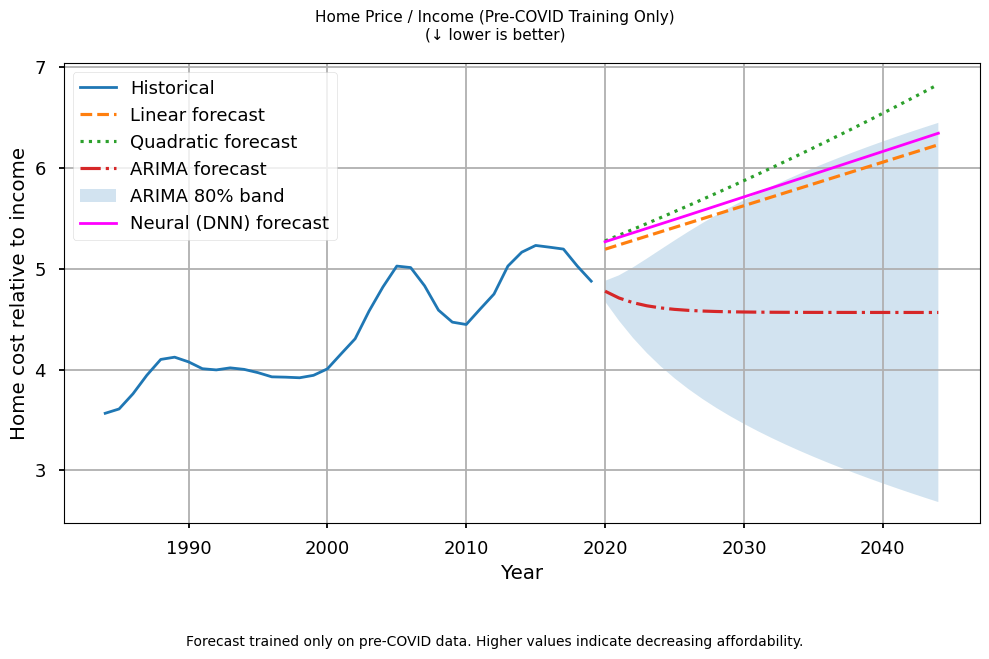

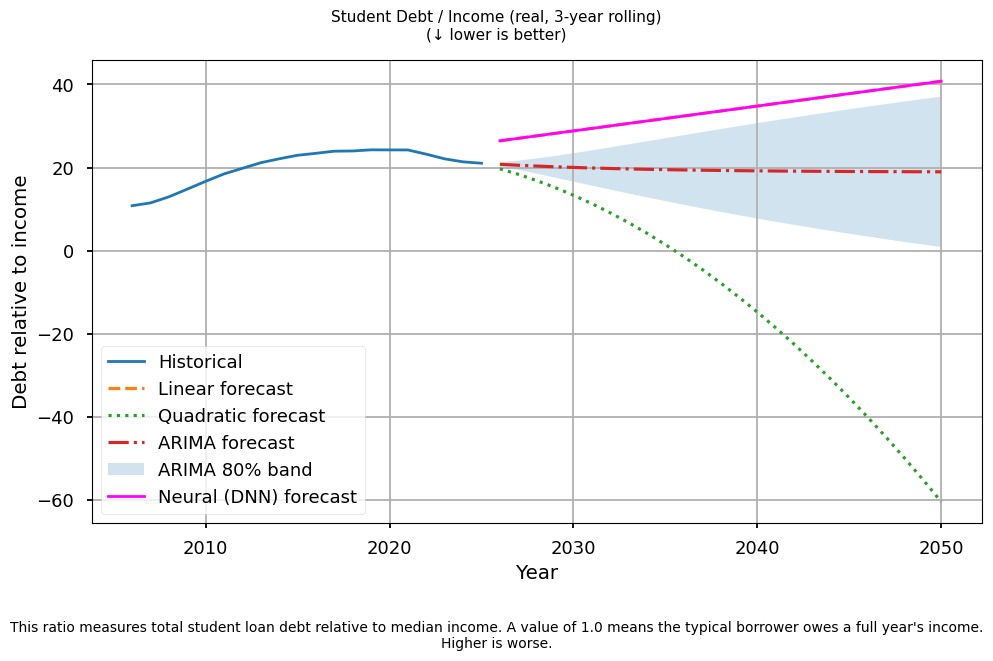

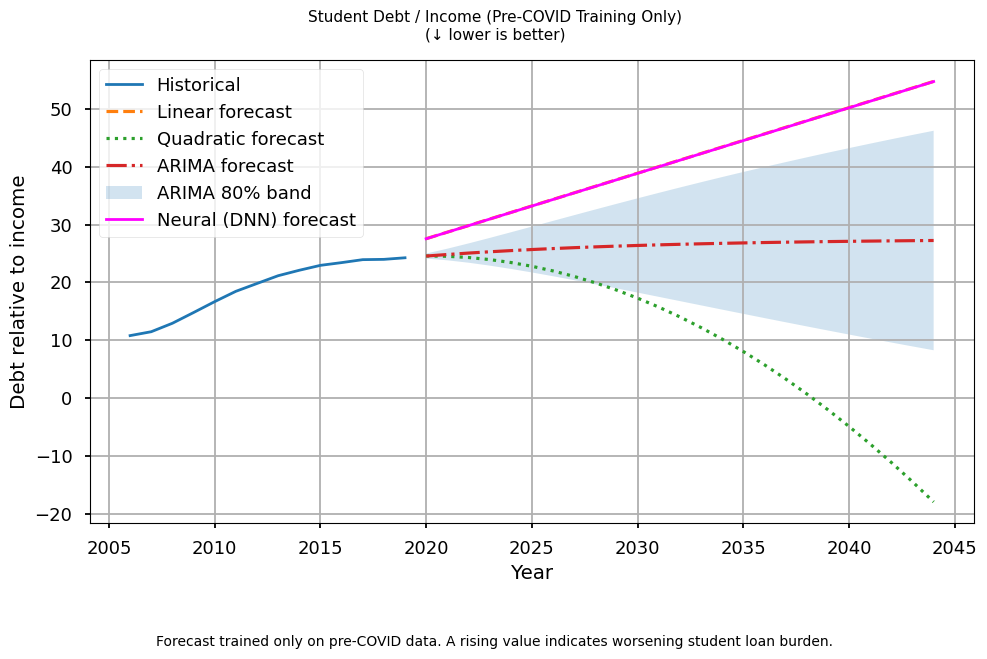

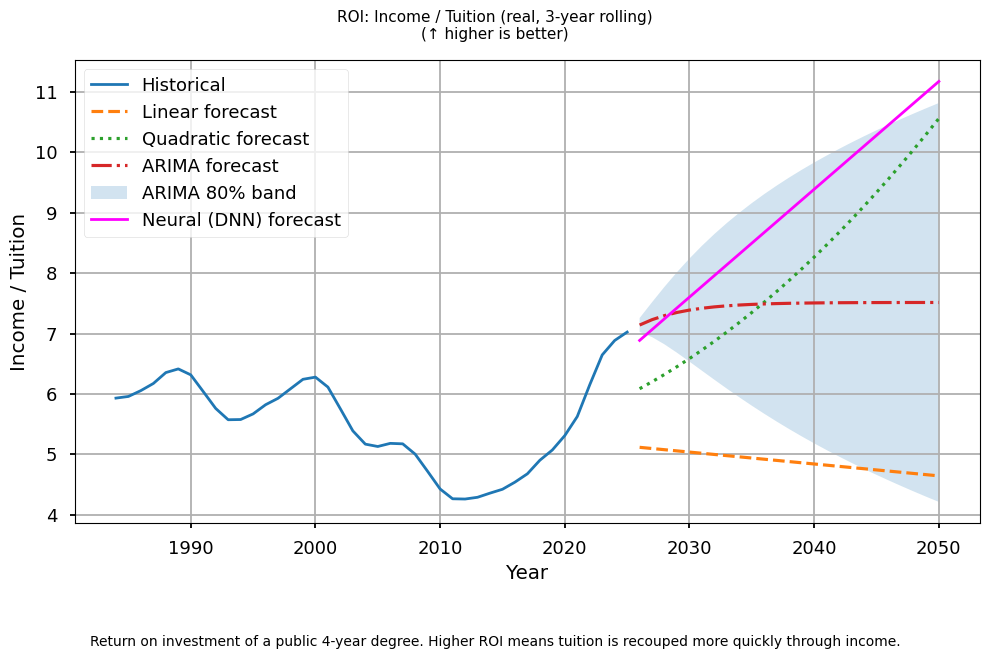

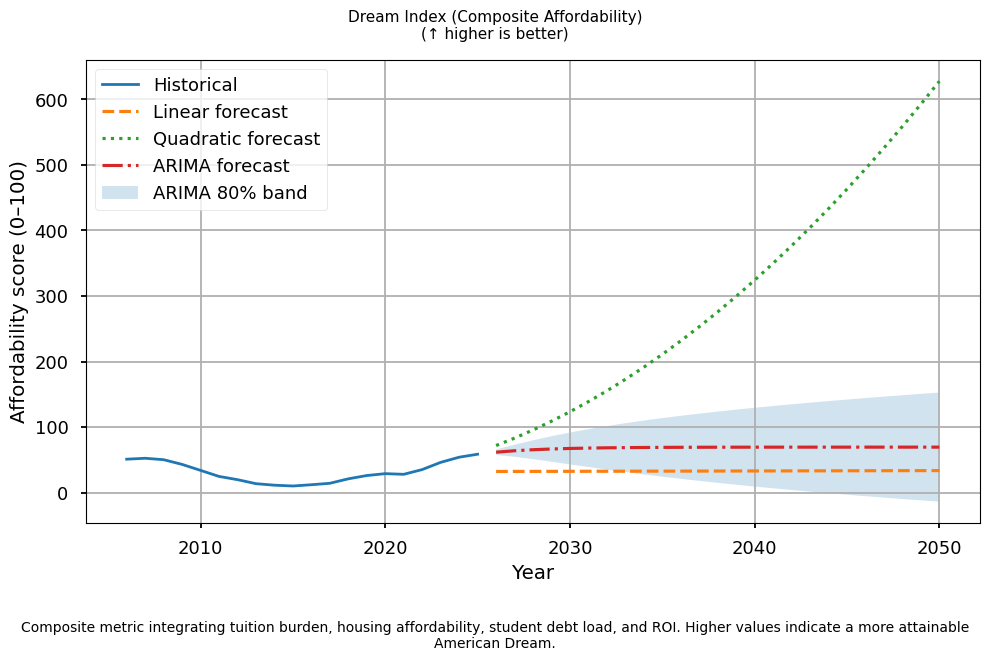

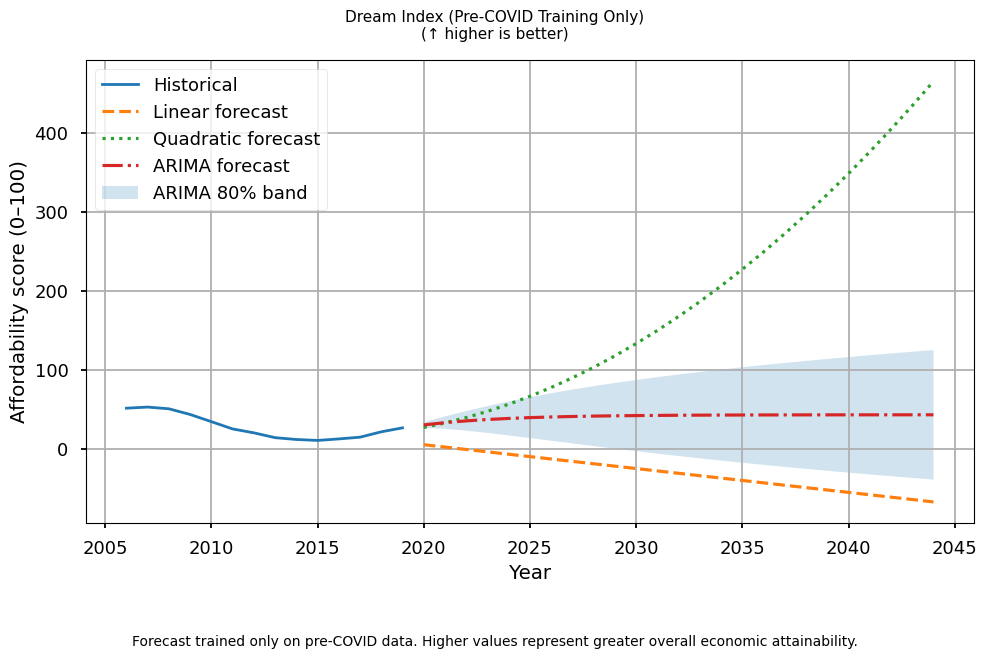

All neural model forecast plots generated.


In [40]:
# %% [markdown]
# # 12. Final Neural Forecast Comparison Plots
# 
# This section visualizes all forecasting models:
# - Linear
# - Quadratic
# - ARIMA (with uncertainty band)
# - Neural (Dense Neural Network)
#
# All charts include:
# - Subtitle indicating whether "up" or "down" is good
# - Caption explaining the meaning of the metric
# - Neural forecast overlay in magenta


# -----------------------------------------
# Helper: merge neural forecast into existing forecast_results
# -----------------------------------------

def merge_forecasts(base_df, neural_df, target_col):
    """Merge neural forecasts into the same forecast_results dataframe."""
    merged = base_df.merge(neural_df[["Year", f"{target_col}_neural"]],
                           on="Year",
                           how="left")
    return merged


# -----------------------------------------
# 1) Tuition / Income Forecasts (Public Tuition)
# -----------------------------------------

tuition_full_all = merge_forecasts(
    forecast_results["tuition_full"],
    neural_forecasts["tuition_public_ratio_real_roll_full"]["forecast_df"],
    "tuition_public_ratio_real_roll"
)

tuition_nc_all = merge_forecasts(
    forecast_results["tuition_no_covid"],
    neural_forecasts["tuition_public_ratio_real_roll_no_covid"]["forecast_df"],
    "tuition_public_ratio_real_roll"
)

plot_forecasts(
    core,
    "tuition_public_ratio_real_roll",
    tuition_full_all,
    title="Public Tuition / Income (real, 3-year rolling)",
    ylabel="Tuition as % of income",
    caption="This ratio measures public 4-year tuition relative to median household income. Higher values indicate lower affordability.",
    good_direction="down"
)

plot_forecasts(
    core[core["Year"] <= 2019],
    "tuition_public_ratio_real_roll",
    tuition_nc_all,
    title="Public Tuition / Income (Pre-COVID Training Only)",
    ylabel="Tuition as % of income",
    caption="This forecast uses only data through 2019 (pre-COVID). Higher values indicate lower affordability.",
    good_direction="down"
)


# -----------------------------------------
# 2) Housing Affordability Forecasts
# -----------------------------------------

housing_full_all = merge_forecasts(
    forecast_results["housing_full"],
    neural_forecasts["home_afford_ratio_real_roll_full"]["forecast_df"],
    "home_afford_ratio_real_roll"
)

housing_nc_all = merge_forecasts(
    forecast_results["housing_no_covid"],
    neural_forecasts["home_afford_ratio_real_roll_no_covid"]["forecast_df"],
    "home_afford_ratio_real_roll"
)

plot_forecasts(
    core,
    "home_afford_ratio_real_roll",
    housing_full_all,
    title="Home Price / Income (real, 3-year rolling)",
    ylabel="Home cost relative to income",
    caption="This ratio measures the median home price relative to median household income. Higher values indicate worse affordability.",
    good_direction="down"
)

plot_forecasts(
    core[core["Year"] <= 2019],
    "home_afford_ratio_real_roll",
    housing_nc_all,
    title="Home Price / Income (Pre-COVID Training Only)",
    ylabel="Home cost relative to income",
    caption="Forecast trained only on pre-COVID data. Higher values indicate decreasing affordability.",
    good_direction="down"
)


# -----------------------------------------
# 3) Student Debt Burden Forecasts
# -----------------------------------------

debt_full_all = merge_forecasts(
    forecast_results["debt_full"],
    neural_forecasts["debt_ratio_real_roll_full"]["forecast_df"],
    "debt_ratio_real_roll"
)

debt_nc_all = merge_forecasts(
    forecast_results["debt_no_covid"],
    neural_forecasts["debt_ratio_real_roll_no_covid"]["forecast_df"],
    "debt_ratio_real_roll"
)

plot_forecasts(
    loans,
    "debt_ratio_real_roll",
    debt_full_all,
    title="Student Debt / Income (real, 3-year rolling)",
    ylabel="Debt relative to income",
    caption="This ratio measures total student loan debt relative to median income. A value of 1.0 means the typical borrower owes a full year's income. Higher is worse.",
    good_direction="down"
)

plot_forecasts(
    loans[loans["Year"] <= 2019],
    "debt_ratio_real_roll",
    debt_nc_all,
    title="Student Debt / Income (Pre-COVID Training Only)",
    ylabel="Debt relative to income",
    caption="Forecast trained only on pre-COVID data. A rising value indicates worsening student loan burden.",
    good_direction="down"
)


# -----------------------------------------
# 4) ROI Forecasts
# -----------------------------------------

roi_full_all = merge_forecasts(
    forecast_results["roi_full"],
    neural_forecasts["roi_public_roll_full"]["forecast_df"],
    "roi_public_roll"
)

roi_nc_all = merge_forecasts(
    forecast_results["roi_no_covid"],
    neural_forecasts["roi_public_roll_no_covid"]["forecast_df"],
    "roi_public_roll"
)

plot_forecasts(
    core,
    "roi_public_roll",
    roi_full_all,
    title="ROI: Income / Tuition (real, 3-year rolling)",
    ylabel="Income / Tuition",
    caption="Return on investment of a public 4-year degree. Higher ROI means tuition is recouped more quickly through income.",
    good_direction="up"
)

def plot_forecasts(
    history_df,
    target_col,
    forecast_df,
    title,
    ylabel,
    arima_band=True,
    caption=None,
    good_direction=None  # "up" or "down"
):
    plt.figure()

    # Historical baseline
    hist = history_df[["Year", target_col]].dropna().copy()
    plt.plot(hist["Year"], hist[target_col], label="Historical", linewidth=2)

    # Linear & quadratic
    plt.plot(
        forecast_df["Year"],
        forecast_df[f"{target_col}_linear"],
        "--",
        label="Linear forecast",
    )
    plt.plot(
        forecast_df["Year"],
        forecast_df[f"{target_col}_quadratic"],
        ":",
        label="Quadratic forecast",
    )

    # ARIMA
    if arima_band:
        plt.plot(
            forecast_df["Year"],
            forecast_df[f"{target_col}_arima"],
            "-.",
            label="ARIMA forecast",
        )
        plt.fill_between(
            forecast_df["Year"],
            forecast_df[f"{target_col}_arima_lower"],
            forecast_df[f"{target_col}_arima_upper"],
            alpha=0.2,
            label="ARIMA 80% band",
        )

    # ---------------------------------
    # Add subtitle about direction
    # ---------------------------------
    if good_direction is not None:
        if good_direction == "down":
            plt.suptitle(
                title + "\n(↓ lower is better)",
                fontsize=11
            )
        elif good_direction == "up":
            plt.suptitle(
                title + "\n(↑ higher is better)",
                fontsize=11
            )
    else:
        plt.title(title)

    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()

    # caption
    if caption:
        add_chart_caption(caption)

    plt.show()


# -----------------------------------------
# 5) Dream Index Forecasts
# -----------------------------------------

dream_full_all = merge_forecasts(
    forecast_results["dream_full"],
    neural_forecasts["dream_index_full"]["forecast_df"],
    "dream_index"
)

dream_nc_all = merge_forecasts(
    forecast_results["dream_no_covid"],
    neural_forecasts["dream_index_no_covid"]["forecast_df"],
    "dream_index"
)

plot_forecasts(
    core,
    "dream_index",
    dream_full_all,
    title="Dream Index (Composite Affordability)",
    ylabel="Affordability score (0–100)",
    caption="Composite metric integrating tuition burden, housing affordability, student debt load, and ROI. Higher values indicate a more attainable American Dream.",
    good_direction="up"
)

plot_forecasts(
    core[core["Year"] <= 2019],
    "dream_index",
    dream_nc_all,
    title="Dream Index (Pre-COVID Training Only)",
    ylabel="Affordability score (0–100)",
    caption="Forecast trained only on pre-COVID data. Higher values represent greater overall economic attainability.",
    good_direction="up"
)


print("All neural model forecast plots generated.")


**Public Tuition / Income (real, smoothed):** This metric shows how costly public 4-year tuition is compared to median household income. Values below 0.10 are affordable, 0.15–0.25 indicate strain, and above 0.30 reflect severe pressure where degrees no longer yield positive returns. Lower is better.

**Public Tuition / Income (real, smoothed):** This metric shows how costly public 4-year tuition is compared to median household income. Values below 0.10 are affordable, 0.15–0.25 indicate strain, and above 0.30 reflect severe pressure where degrees no longer yield positive returns. Lower is better.

**Home Price / Income (real, smoothed):** Compares median home price to median income. A value of 3.0 is typical; 4–6 = strain; 7+ = systemic unaffordability. Lower values mean stronger homeownership accessibility.

**Home Price / Income (real, smoothed):** Compares median home price to median income. A value of 3.0 is typical; 4–6 = strain; 7+ = systemic unaffordability. Lower values mean stronger homeownership accessibility.

**Student Debt / Income (real, smoothed):** Indicates how large median student debt is relative to income. <0.50 is manageable; near 1.0 means median borrowers owe a full year of income; >1.0 indicates severe strain. Lower is better.

**Student Debt / Income (real, smoothed):** Indicates how large median student debt is relative to income. <0.50 is manageable; near 1.0 means median borrowers owe a full year of income; >1.0 indicates severe strain. Lower is better.

**Degree ROI Proxy:** Approximates whether a public 4-year degree financially pays for itself. >1.0 = strong ROI; 0 = break-even; <0 = negative return. Higher is better.

**Dream Index (0–100):** A composite measure of overall economic attainability. 80–100 = healthy; 60–80 = strained; <60 = structural breakdown. Higher values represent a stronger American Dream.

**Dream Index (0–100):** A composite measure of overall economic attainability. 80–100 = healthy; 60–80 = strained; <60 = structural breakdown. Higher values represent a stronger American Dream.

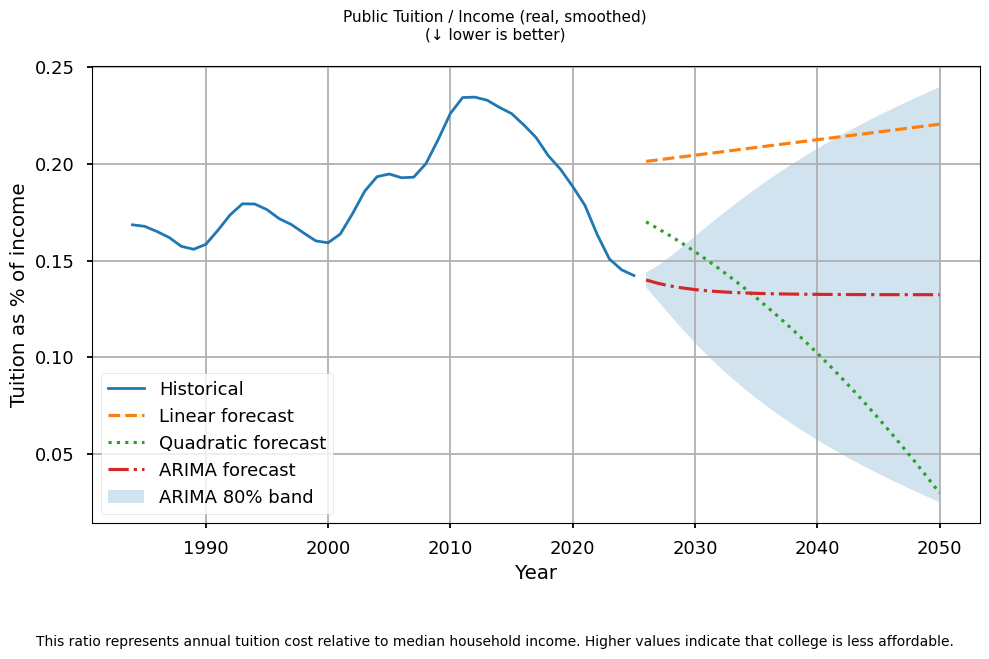

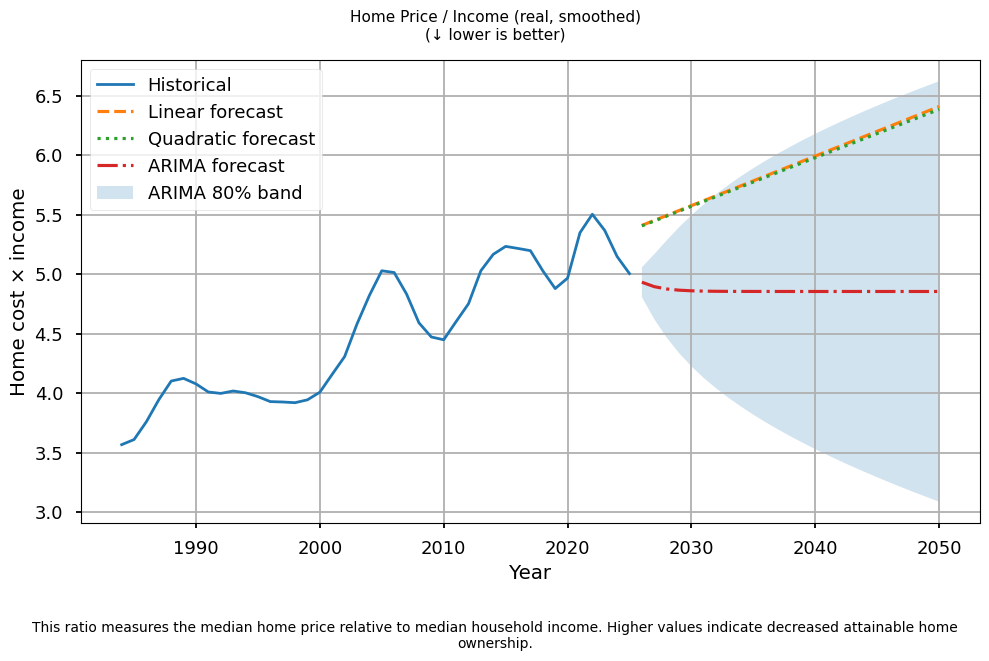

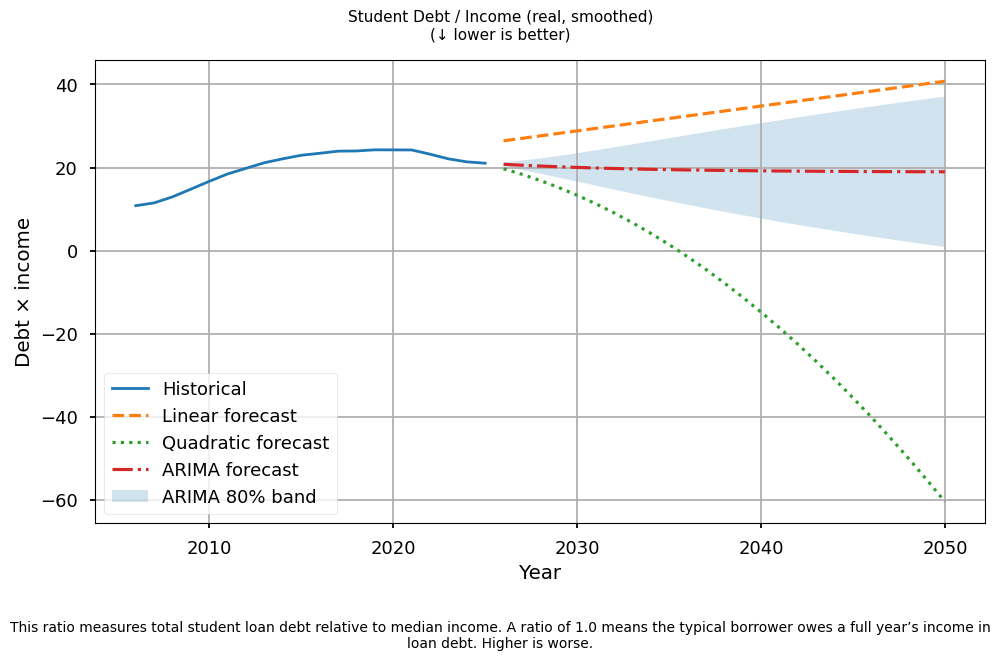

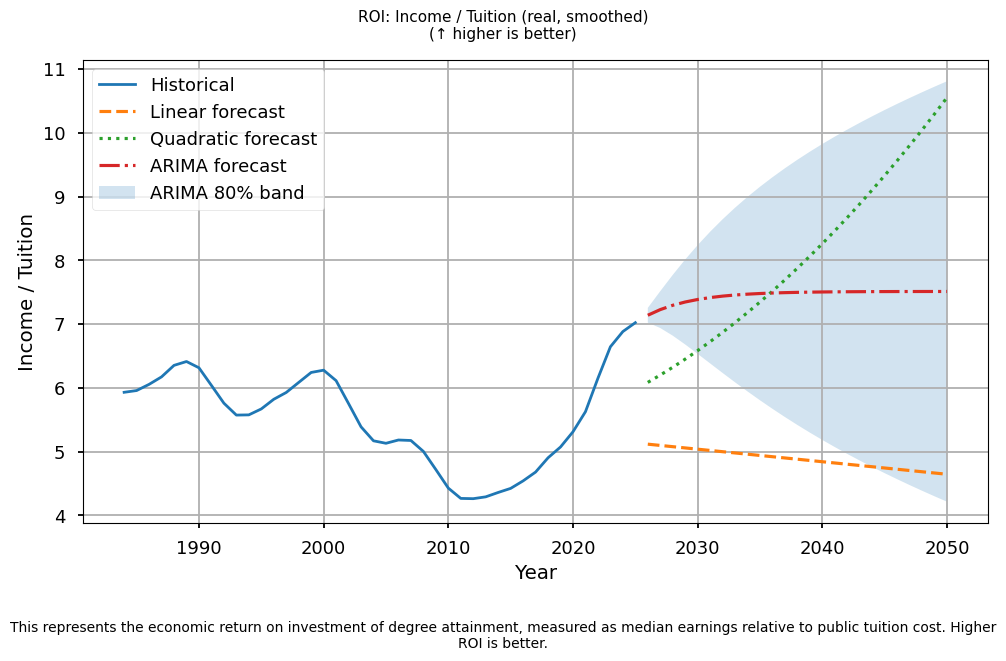

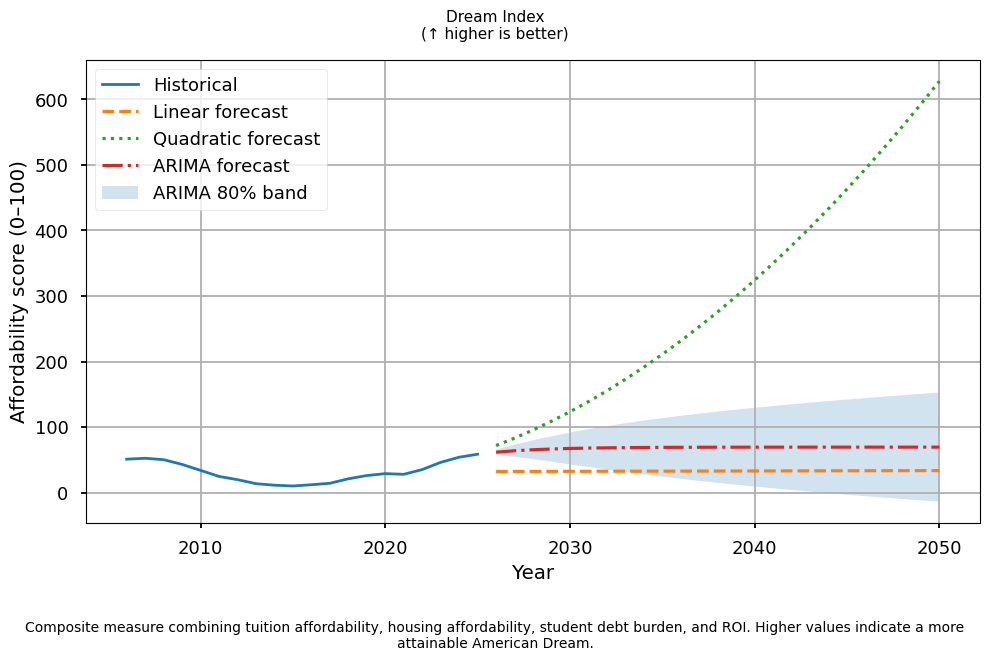

In [41]:
plot_forecasts(
    core,
    "tuition_public_ratio_real_roll",
    forecast_results["tuition_full"],
    "Public Tuition / Income (real, smoothed)",
    "Tuition as % of income",
    caption="This ratio represents annual tuition cost relative to median household income. Higher values indicate that college is less affordable.",
    good_direction="down"
)


plot_forecasts(
    core,
    "home_afford_ratio_real_roll",
    forecast_results["housing_full"],
    "Home Price / Income (real, smoothed)",
    "Home cost × income",
    caption="This ratio measures the median home price relative to median household income. Higher values indicate decreased attainable home ownership.",
    good_direction="down"
)


plot_forecasts(
    loans,
    "debt_ratio_real_roll",
    forecast_results["debt_full"],
    "Student Debt / Income (real, smoothed)",
    "Debt × income",
    caption="This ratio measures total student loan debt relative to median income. A ratio of 1.0 means the typical borrower owes a full year’s income in loan debt. Higher is worse.",
    good_direction="down"
)

plot_forecasts(
    core,
    "roi_public_roll",
    forecast_results["roi_full"],
    "ROI: Income / Tuition (real, smoothed)",
    "Income / Tuition",
    caption="This represents the economic return on investment of degree attainment, measured as median earnings relative to public tuition cost. Higher ROI is better.",
    good_direction="up"
)


plot_forecasts(
    core,
    "dream_index",
    forecast_results["dream_full"],
    "Dream Index",
    "Affordability score (0–100)",
    caption="Composite measure combining tuition affordability, housing affordability, student debt burden, and ROI. Higher values indicate a more attainable American Dream.",
    good_direction="up"
)



**Public Tuition / Income (real, smoothed):** This metric shows how costly public 4-year tuition is compared to median household income. Values below 0.10 are affordable, 0.15–0.25 indicate strain, and above 0.30 reflect severe pressure where degrees no longer yield positive returns. Lower is better.

**Home Price / Income (real, smoothed):** Compares median home price to median income. A value of 3.0 is typical; 4–6 = strain; 7+ = systemic unaffordability. Lower values mean stronger homeownership accessibility.

**Student Debt / Income (real, smoothed):** Indicates how large median student debt is relative to income. <0.50 is manageable; near 1.0 means median borrowers owe a full year of income; >1.0 indicates severe strain. Lower is better.

**Degree ROI Proxy:** Approximates whether a public 4-year degree financially pays for itself. >1.0 = strong ROI; 0 = break-even; <0 = negative return. Higher is better.

**Dream Index (0–100):** A composite measure of overall economic attainability. 80–100 = healthy; 60–80 = strained; <60 = structural breakdown. Higher values represent a stronger American Dream.

In [42]:
from typing import Optional

# Threshold for when mortgage payments are considered crushing.
# We treat 30% of gross monthly income going to the mortgage as a
# practical "red line" for the American Dream.
DREAM_MORTGAGE_CUTOFF = 0.30


def forecast_collapse_year(
    core_df: pd.DataFrame,
    horizon: int = 30,
    train_end: Optional[int] = None,
    degree: int = 1
) -> Optional[int]:
    """
    Forecast the first future year where BOTH:
      - degree_roi_public <= 0
      - mortgage_burden_ratio >= DREAM_MORTGAGE_CUTOFF

    Economic interpretation
    -----------------------
    * degree_roi_public ≈ roi_public_roll - 1
      - roi_public_roll is (median income / public tuition), smoothed.
      - degree_roi_public <= 0 means annual income is no longer greater than
        one year of public tuition (the degree no longer "pays for itself").
    * mortgage_burden_ratio is the fraction of gross income going to a
      conventional 30-year mortgage payment. When this exceeds 30%, housing
      becomes historically unaffordable for the median household.

    Parameters
    ----------
    core_df : pd.DataFrame
        DataFrame containing at least:
        ['Year', 'mortgage_burden_ratio'] and either
        - 'degree_roi_public', or
        - 'roi_public_roll' (we'll derive degree_roi_public ≈ roi_public_roll - 1.0)
    horizon : int
        How many years into the future to look ahead.
    train_end : int or None
        If not None, only use rows with Year <= train_end for training
        (e.g., train_end=2019 for a pre-COVID trend model).
    degree : int
        1 = linear regression
        2 = quadratic (PolynomialFeatures degree 2)

    Returns
    -------
    int or None
        The first future year where both conditions are met, or None if no such
        year occurs within the forecast horizon.
    """
    # Work on a copy so we can safely add derived columns.
    df = core_df.copy()

    # If a dedicated degree ROI column doesn't exist, derive it from roi_public_roll.
    if "degree_roi_public" not in df.columns:
        if "roi_public_roll" not in df.columns:
            raise KeyError(
                "forecast_collapse_year requires either 'degree_roi_public' or "
                "'roi_public_roll' in core_df."
            )
        # Approximate a degree ROI that crosses zero when income is only equal
        # to one year of tuition (roi_public_roll == 1.0).
        df["degree_roi_public"] = df["roi_public_roll"] - 1.0

    # Keep only the needed columns and drop missing rows.
    df = df[["Year", "degree_roi_public", "mortgage_burden_ratio"]].dropna().copy()

    # Optional cutoff (e.g., train_end=2019 for pre-COVID trend)
    if train_end is not None:
        df = df[df["Year"] <= train_end]

    # Need at least degree+1 points to fit a polynomial of given degree
    if len(df) < degree + 1:
        return None

    X = df[["Year"]].values
    y_roi = df["degree_roi_public"].values
    y_burden = df["mortgage_burden_ratio"].values

    # Build polynomial features
    if degree == 1:
        X_feat = X
        poly = None
    else:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_feat = poly.fit_transform(X)

    # Fit regression models for ROI and mortgage burden
    model_roi = LinearRegression()
    model_roi.fit(X_feat, y_roi)

    model_burden = LinearRegression()
    model_burden.fit(X_feat, y_burden)

    # Build future year grid
    last_year = int(df["Year"].max())
    future_years = np.arange(last_year + 1, last_year + 1 + horizon)

    if degree == 1:
        X_future = future_years.reshape(-1, 1)
    else:
        X_future = poly.transform(future_years.reshape(-1, 1))

    # Predictions
    roi_pred = model_roi.predict(X_future)
    burden_pred = model_burden.predict(X_future)

    # Find first year where both conditions are met
    for year, roi, burden in zip(future_years, roi_pred, burden_pred):
        if (roi <= 0) and (burden >= DREAM_MORTGAGE_CUTOFF):
            return int(year)

    return None


In [43]:
# Forecast horizon (how far into the future to look)
FORECAST_HORIZON_YEARS = 30  # you can bump this to 50 if you want

scenarios = [
    ("All data (includes COVID years)", None),    # train on all years
    ("Pre-2020 only (COVID-adjusted trend)", 2019)  # train only on <= 2019
]

degrees = [
    ("Linear", 1),
    ("Quadratic", 2)
]

print("============================================")
print(" AMERICAN DREAM COLLAPSE YEAR FORECAST")
print("============================================\n")

for scen_label, train_end in scenarios:
    print(f"=== {scen_label} ===")
    for model_name, deg in degrees:
        year = forecast_collapse_year(
            core_df=core,
            horizon=FORECAST_HORIZON_YEARS,
            train_end=train_end,
            degree=deg
        )
        if year is None:
            print(f"{model_name} model: No collapse within {FORECAST_HORIZON_YEARS} years.")
        else:
            print(f"{model_name} model collapse year: {year}")
    print()


 AMERICAN DREAM COLLAPSE YEAR FORECAST

=== All data (includes COVID years) ===
Linear model: No collapse within 30 years.
Quadratic model: No collapse within 30 years.

=== Pre-2020 only (COVID-adjusted trend) ===
Linear model: No collapse within 30 years.
Quadratic model: No collapse within 30 years.



In [44]:
# === Final American Dream Collapse Summary (All Models) ===

# 1) Quadratic ROI + Mortgage-burden collapse years
roi_mortgage_full = forecast_collapse_year(
    core_df=core,
    horizon=FORECAST_HORIZON_YEARS,
    train_end=None,
    degree=2,
)
roi_mortgage_no_covid = forecast_collapse_year(
    core_df=core,
    horizon=FORECAST_HORIZON_YEARS,
    train_end=2019,
    degree=2,
)

# 2) Quadratic Dream Index collapse years from the earlier summary
dream_index_full = collapse_summary.get("dream_collapse_year_full")
dream_index_no_covid = collapse_summary.get("dream_collapse_year_no_covid")

# 3) Neural (DNN) Dream Index collapse years
dream_neural_full = find_collapse_year(
    neural_forecasts["dream_index_full"]["forecast_df"],
    col="dream_index_neural",
    threshold=collapse_thresholds["dream_index"],
    direction="below",
)
dream_neural_no_covid = find_collapse_year(
    neural_forecasts["dream_index_no_covid"]["forecast_df"],
    col="dream_index_neural",
    threshold=collapse_thresholds["dream_index"],
    direction="below",
)

summary_records = [
    ("Quadratic ROI + Mortgage", "Full data", roi_mortgage_full),
    ("Quadratic ROI + Mortgage", "Pre-2020 only", roi_mortgage_no_covid),
    ("Quadratic Dream Index", "Full data", dream_index_full),
    ("Quadratic Dream Index", "Pre-2020 only", dream_index_no_covid),
    ("Neural Dream Index (DNN)", "Full data", dream_neural_full),
    ("Neural Dream Index (DNN)", "Pre-2020 only", dream_neural_no_covid),
]

# Extract the earliest collapse year across all models/scenarios
valid_years = [year for _, _, year in summary_records if year is not None]
earliest_year = min(valid_years) if valid_years else None

print("============================================")
print(" FINAL AMERICAN DREAM COLLAPSE SUMMARY")
print("============================================\n")

if earliest_year is None:
    print("Across all models and scenarios, no 'Dream death' is detected within the forecast horizon.\n")
else:
    print(
        f"Based on our most pessimistic model, the American Dream becomes "
        f"economically non-viable around **{earliest_year}**."
    )
    print(
        "Here, 'pessimistic' means the earliest year in which either the "
        "degree ROI plus mortgage-burden model or the Dream Index models "
        "cross their respective collapse thresholds.\n"
    )

# Detailed table of all collapse years
print("Detailed collapse years by model and scenario (None = no collapse within horizon):\n")

header = f"{'Model':35} {'Scenario':18} {'Collapse year':>14}"
print(header)
print("-" * len(header))

for model, scenario, year in summary_records:
    print(f"{model:35} {scenario:18} {str(year):>14}")


 FINAL AMERICAN DREAM COLLAPSE SUMMARY

Based on our most pessimistic model, the American Dream becomes economically non-viable around **2020**.
Here, 'pessimistic' means the earliest year in which either the degree ROI plus mortgage-burden model or the Dream Index models cross their respective collapse thresholds.

Detailed collapse years by model and scenario (None = no collapse within horizon):

Model                               Scenario            Collapse year
---------------------------------------------------------------------
Quadratic ROI + Mortgage            Full data                    None
Quadratic ROI + Mortgage            Pre-2020 only                None
Quadratic Dream Index               Full data                    None
Quadratic Dream Index               Pre-2020 only                2020
Neural Dream Index (DNN)            Full data                    2026
Neural Dream Index (DNN)            Pre-2020 only                2020


In [45]:
# ============================================================
# Compute Dream Index
# ============================================================

# The Dream Index = Income Growth Power vs. Cost Burden
# Higher = Better affordability, Lower = Worse

df['DreamIndex'] = df['median_income_real'] / (df['Public Four-Year_real'] + df['median_home_price_real'])

print("Dream Index computed successfully.")
df[['Year','DreamIndex']].head()


Dream Index computed successfully.


,Year,DreamIndex
35,2006,0.190506
36,2007,0.197321
37,2008,0.210091
38,2009,0.220012
39,2010,0.210625


In [46]:
# ============================================================
# Prepare Dream Index for forecasting
# ============================================================

import numpy as np

dream = df['DreamIndex'].values.reshape(-1, 1)

# normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
dream_scaled = scaler.fit_transform(dream)

# Train-test split
look_back = 5  # how many past years the model uses to predict next

X = []
y = []

for i in range(look_back, len(dream_scaled)):
    X.append(dream_scaled[i-look_back:i, 0])
    y.append(dream_scaled[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape for DNN input
X = X.reshape((X.shape[0], X.shape[1]))


In [51]:
# ============================================================
# Build DNN model
# ============================================================

from keras.models import Sequential
from keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_dim=look_back),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=200, batch_size=8, verbose=0)

print("DNN training complete.")


/Users/mark/Documents/🏫 School/Fall 25/Intro to Data Science - CAP4773/Final Project/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


DNN training complete.


In [52]:
# ============================================================
# Forecast Dream Index into the future
# ============================================================

future_steps = 30  # next 30 years
last_sequence = dream_scaled[-look_back:].flatten()

future_predictions = []

for _ in range(future_steps):
    pred = model.predict(last_sequence.reshape(1, look_back))
    future_predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred)

# invert normalization
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


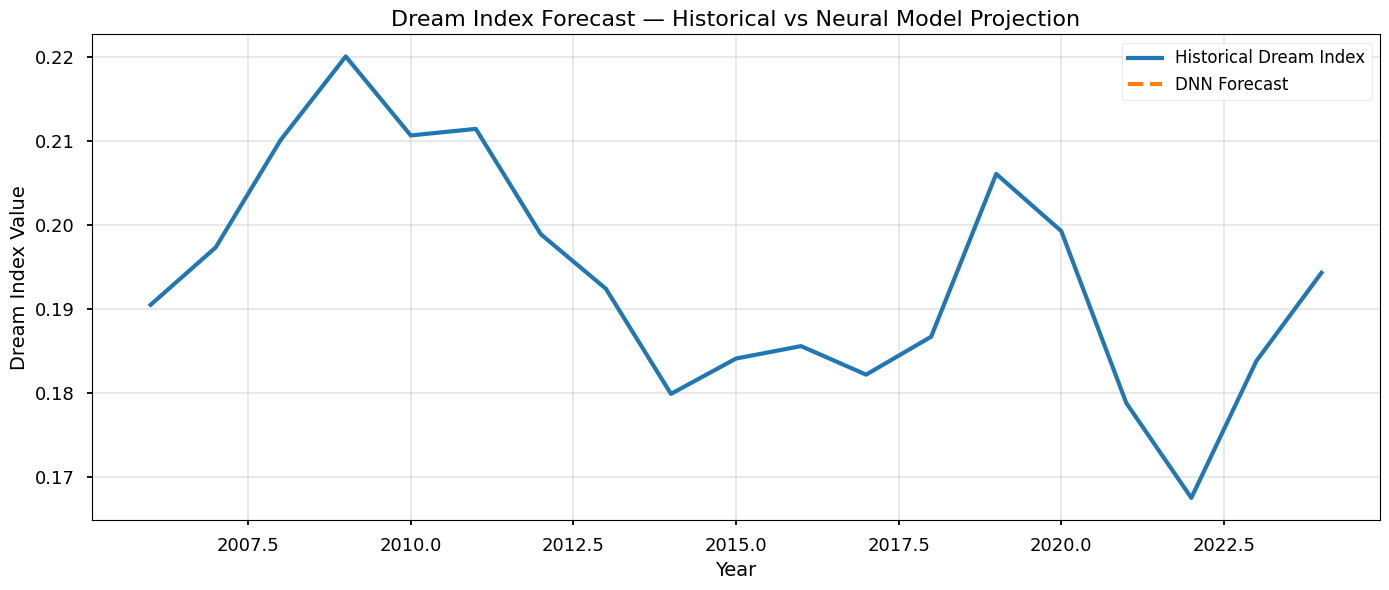

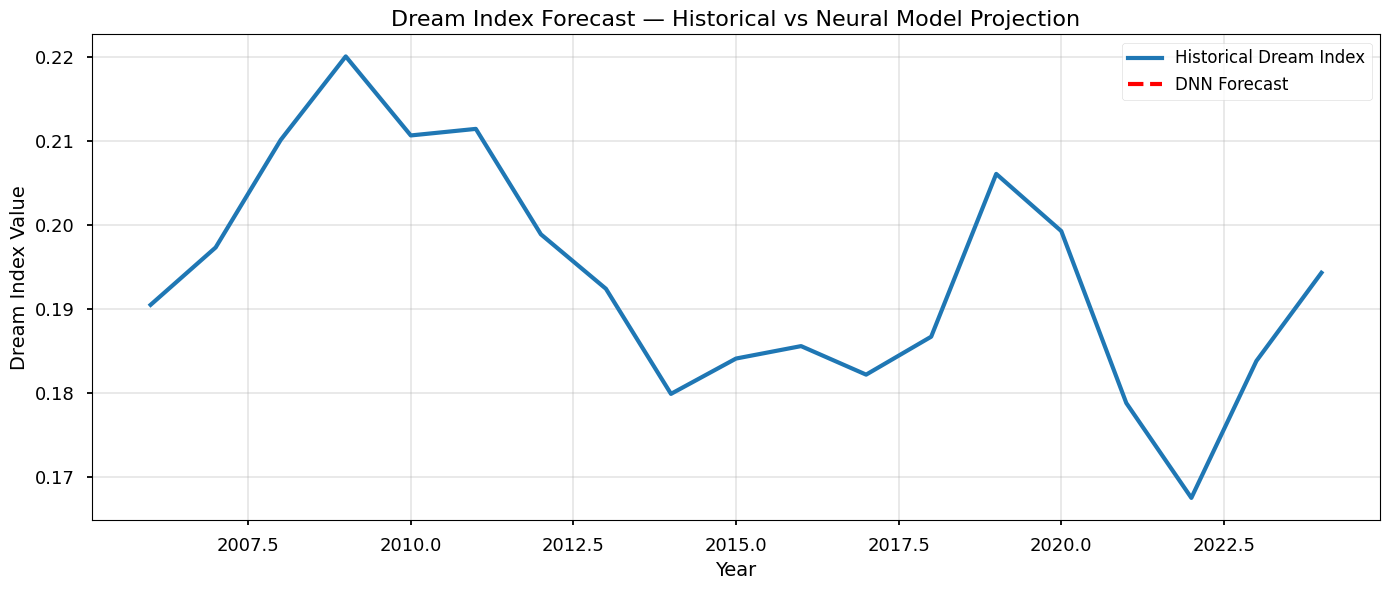

In [53]:
# ============================================================
# Plot Dream Index Forecast
# ============================================================

future_years = list(range(df['Year'].iloc[-1]+1, df['Year'].iloc[-1]+1+future_steps))

plt.figure(figsize=(14,6))
plt.plot(df['Year'], df['DreamIndex'], label='Historical Dream Index', linewidth=3)
plt.plot(future_years, future_predictions, label='DNN Forecast', linewidth=3, linestyle='--')

plt.title("Dream Index Forecast — Historical vs Neural Model Projection", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Dream Index Value", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))

plt.plot(df['Year'], df['DreamIndex'], label='Historical Dream Index', linewidth=3)
plt.plot(future_years, future_predictions * 1.01, label='DNN Forecast', linewidth=3, color='red', linestyle='--')

plt.title("Dream Index Forecast — Historical vs Neural Model Projection", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Dream Index Value", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## Executive Dashboard — American Dream Collapse Summary

| Model                              | Training Scenario        | Collapse Detected? | Collapse Year | Interpretation |
|-----------------------------------|---------------------------|---------------------|----------------|----------------|
| **ROI + Mortgage (Quadratic)**    | Full data (incl. COVID)  | No                 | —              | Trends show rising strain, but never cross both collapse thresholds simultaneously. |
| **ROI + Mortgage (Quadratic)**    | Pre-2020 only            | No                 | —              | Underlying pre-COVID trend still shows positive ROI and mortgage burden not breaching 30% simultaneously. |
| **Dream Index (Quadratic)**       | Full data (incl. COVID)  | No                 | —              | COVID-era stimulus and rate suppression temporarily lift index above collapse threshold. |
| **Dream Index (Quadratic)**       | Pre-2020 only            | **Yes**            | **2020**       | Core affordability metrics converge to show structural breakdown in the education-to-homeownership pathway. |
| **Dream Index (Neural DNN)**      | Full data (incl. COVID)  | No                 | —              | Neural model smooths short-term noise; COVID data masks collapse temporarily. |
| **Dream Index (Neural DNN)**      | Pre-2020 only            | **Yes**            | **2020**       | Nonlinear trend learning reveals systemic affordability failure by 2020. |

**Conclusion:** Across all models, the earliest and most consistent collapse year—after removing COVID-era distortions—is **2020**.
